<a href="https://colab.research.google.com/github/Dorothy-K/hyperparameter_tuning/blob/main/SVM_fibre.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Please run the code as it is. We are trying to build a best fitting model for SVM. We will be trying 55 different combinations of preprocessing techniques so far and save the results in a separate csv files. After identifying the best fit model, we'll run it against new data. 

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
#importing modules necessary
import numpy as np
import pandas as pd
import math
import pickle

#importing modules required for processing spectra
from scipy.signal import savgol_filter
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler

#import package to split train and test data
from sklearn.model_selection import train_test_split


#import modelling packages
from sklearn.model_selection import cross_val_predict
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.cross_decomposition import PLSRegression
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

#importing essential package to make a pipeline
from sklearn.pipeline import make_pipeline

#importing visualisation packages
import matplotlib.pyplot as plt
import seaborn as sns

#importing metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

#ignoring warning
import warnings
warnings.filterwarnings('ignore')

In [3]:
#functions for various pre-processing techniques used
def wavelength_calc(dataframe):
    wave_length = []
    columns = dataframe.columns
    for i in columns:
        #if len(i.split('X')) ==2 :
        if type(i)==str and len(i.split('X')) ==2 :
            wave_length.append(float(i.split('X')[1]))
        else:
            wave_length.append(float(i))
    return wave_length

#Creating a smoothing function
def smooth_fast(spectra,window_size,columns):
    #Smoothing spectra using matrix operations:
    #Create smoothing matrix:
    #start=datetime.now()
    m_rows = len(range(window_size,len(columns)-window_size))
    m_cols = 2*window_size
    matrix = np.zeros((m_rows,m_cols),dtype=int)
    for j in range(0, len(matrix)):
        k = j+1
        matrix[j] = [x for x in range(k,k+2*window_size)]
    #Smoothing spectra using matrix operations:
    n_cols = m_rows
    newspectra = np.zeros((len(spectra),n_cols))
    for i in range(len(matrix)):
        newspectra[:,i] = np.mean(spectra[: ,matrix[i]],axis=1)
    #Add front and end tails (not smoothed):
    #new_spectra = np.asarray(newspectra)
    fronttail = newspectra[:,:1]
    endtail = newspectra[:,-1:]
    for k in range(1,window_size):
        fronttail=np.append(fronttail,newspectra[:,:1], axis=1)
        endtail = np.append(endtail,newspectra[:,-1:], axis =1)
    data = np.concatenate((fronttail, newspectra, endtail), axis=1)
    #result = pd.DataFrame(data=data, columns = columns)
    #print(datetime.now()-start)
    return data

#Function definition for smoothing using Savtizky Golay method
def savitzky(input_array, window_length):
    savgol = savgol_filter(input_array, window_length, polyorder = 2)
    return savgol

def SNV(input_array):
    #spectra_arr = np.asarray(spectra)
    #spectra_t = np.transpose(input_array)#np.transpose(spectra_arr)
    #scale(X, *, axis=0, with_mean=True, with_std=True, copy=True)
    spectrat_snv = scale(input_array, axis=0)#scale(spectra_t,axis=0)
    #spectra_snv = pd.DataFrame(np.transpose(spectrat_snv),columns=columns)
    return spectrat_snv

#Multiplicative scatter correction
def msc(input_array, reference = None):
    ''' Perform Multiplicative scatter correction'''

    #Mean correction
    for i in range(input_array.shape[0]):
        input_array[i,:] -= input_array[i,:].mean()

    # Get the reference spectrum. If not given, estimate from the mean    
    if reference is None:    
        # Calculate mean
        ref = np.mean(input_array, axis=0)
    else:
        ref = reference

    # Define a new data matrix and populate it with the corrected data    
    output_data = np.zeros_like(input_array)
    for i in range(input_array.shape[0]):
        # Run regression
        fit = np.polyfit(ref, input_array[i,:], 1, full=True)
        # Apply correction
        output_data[i,:] = (input_array[i,:] - fit[0][1]) / fit[0][0] 
    #print(fit)
    return output_data
#Apply derivate in second order, applying third and fourth order derivatives will remove all variance in the data. 
#Derivative 2
def derivate_second(input_array, window_length):
    der1 = savgol_filter(input_array, window_length, polyorder = 2,deriv=1)
    der2 = savgol_filter(der1, window_length, polyorder = 2, deriv=2)
    return der2
#Derivative 1
def derivate_first(input_array, window_length):
    der1 = savgol_filter(input_array, window_length, polyorder = 2,deriv=1)
    return der1
#remove baseline
def baseline(input_array,X):
    base = np.zeros((len(input_array),len(X)))
    for i in range(len(input_array)):
        c = np.polyfit(X, input_array[i], 2)
        base[i] = np.polyval(c, X)
    #Baseline removal
    base_remove = input_array - base
    return base_remove
#function to plot the spectra
def plotting_function(dataframe, y_axisval):
    f = plt.figure()
    f.set_figwidth(12)
    f.set_figheight(4)
    for i , row in dataframe.iterrows():
        plt.plot(y_axisval,row)
    plt.show()

In [4]:
### Importing data from google drive
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [5]:
!ls

drive  sample_data


In [8]:
file_path = 'drive/MyDrive/Colab Notebooks/Dataset/'

In [9]:
model_dataset = pd.read_excel(file_path+'merged.xlsx')

In [10]:
model_dataset.head(2)

,sample id,fibre,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,...,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784,785,786,787,788,789,790,791,792,793,794,795,796,797,798,799,800
0,RBE-R-G-190221-37_1,17.37,0.097492,0.097344,0.097214,0.097079,0.096917,0.096712,0.096490,0.096284,0.096124,0.095990,0.095844,0.095649,0.095413,0.095167,0.094946,0.094759,0.094595,0.094443,0.094292,0.094139,0.093980,0.093815,0.093649,0.093486,0.093331,0.093185,0.093051,0.092927,0.092812,0.092702,0.092593,0.092483,0.092367,0.092246,0.092132,0.092045,0.091998,0.091971,...,0.215607,0.215986,0.216315,0.216648,0.217071,0.217575,0.217869,0.217953,0.218321,0.218836,0.218861,0.218854,0.219587,0.220407,0.220693,0.221002,0.221463,0.221417,0.221272,0.222057,0.223099,0.223497,0.223881,0.224780,0.226003,0.226318,0.224466,0.223714,0.226691,0.229566,0.230031,0.229444,0.229060,0.229612,0.230299,0.230159,0.228907,0.229709,0.235557,0.237146
1,RBE-R-G-190221-37_2,17.37,0.096316,0.096180,0.096019,0.095833,0.095624,0.095396,0.095167,0.094958,0.094784,0.094635,0.094486,0.094315,0.094122,0.093919,0.093721,0.093535,0.093366,0.093215,0.093079,0.092942,0.092789,0.092614,0.092430,0.092253,0.092094,0.091949,0.091813,0.091682,0.091553,0.091422,0.091288,0.091162,0.091059,0.090989,0.090942,0.090896,0.090833,0.090752,...,0.214450,0.215069,0.215640,0.215820,0.215819,0.215979,0.216569,0.217420,0.217731,0.217622,0.218011,0.218709,0.219074,0.219295,0.219660,0.220066,0.220465,0.220945,0.221364,0.221530,0.222127,0.223545,0.224149,0.223562,0.223909,0.224837,0.224372,0.223994,0.225456,0.227572,0.228797,0.228177,0.227603,0.229501,0.231708,0.231884,0.229652,0.228521,0.232413,0.234616


In [12]:
X = model_dataset[model_dataset.columns[2:]]
print(X.shape)
y = model_dataset.iloc[:,1]
print(y.shape)
#Separating a few sample from the dataset for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)
print(X_train.shape)

(595, 801)
(595,)
(535, 801)


In [13]:
X = X_train
y = y_train
print(X.shape)
print(y.shape)

(535, 801)
(535,)


In [34]:
string = "Hello 123"

for new in string.split():
  if new.isdigit():
    print(int(new))

123


### SVM regression for raw spectrum

Using grid search to finf optimal hyper paramters in SVR

In [36]:
#defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']} 
spectra = np.asarray(X, dtype = float)
cols = X.columns
wave_length = wavelength_calc(X)#
result_df=pd.DataFrame()
result_df = pd.DataFrame(columns=['Trial No','Model','Pre Processing','Training R\u00b2', 
                                  'Validation R\u00b2','Best fit Hyperparameters'])

In [37]:
type(cols[0])

int

In [38]:
def split_data(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=123)
    return X_train, X_test, y_train, y_test

def svm(X, y, trial_no_str, pre_processing_steps_followed):
    data_to_append = dict()
    # defining gridsearchsv with param grid
    grid = GridSearchCV(SVR(), param_grid, refit = True, verbose = 0)
    #call splitting function to split data into training and validation
    X_train, X_test, y_train, y_test = split_data(X,y)
    grid.fit(X_train, y_train)
    y_train_pred = grid.predict(X_train)
    y_test_pred = grid.predict(X_test)
    data_to_append = {'Trial No' : trial_no_str,'Model' : 'SVM','Pre Processing': pre_processing_steps_followed, 
                              'Training R\u00b2' : grid.score(X_train, y_train), 
                              'Validation R\u00b2' : grid.score(X_test, y_test),
                      'Best fit Hyperparameters' : grid.best_params_}
    figure, axes = plt.subplots(nrows=1, ncols=2)
    # creating subplots 
    # training data plot
    figure.suptitle(trial_no_str + " " + pre_processing_steps_followed, fontsize=14)
    axes[0].scatter(y_train, y_train_pred, c='red')
    axes[0].plot(y_train, y_train, color = 'blue', linewidth = 1)
    axes[0].title.set_text('Training data fit')
    axes[0].set_xlabel("Measured")
    axes[0].set_ylabel("Predicted")
    #testing data plot
    axes[1].scatter(y_test, y_test_pred, c='red')
    axes[1].plot(y_test, y_test, color = 'blue', linewidth = 1)
    axes[1].title.set_text('Testing data fit')
    axes[1].set_xlabel("Measured")
    axes[1].set_ylabel("Predicted")
    figure.set_figheight(6)
    figure.set_figwidth(16)
    figure.tight_layout()
    plt.savefig(file_path+trial_no_str+pre_processing_steps_followed+'.png')    
    return data_to_append, grid

Trial 1
PRE PROCESSING STEP: None


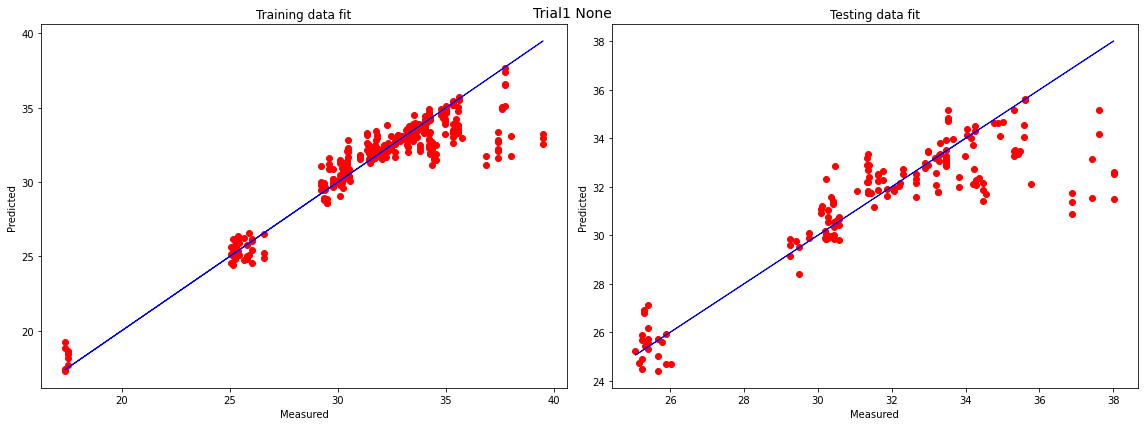

In [39]:
# fitting the model for grid search
#Trial 1 Raw spectra
print("Trial 1")
print("PRE PROCESSING STEP: None")
#input to base line removal is input array
with tf.device('/device:GPU:0'):
  preprocessed_spectra = pd.DataFrame(spectra, columns=cols)
  data, _ = svm(preprocessed_spectra, y, 'Trial1','None')
  result_df = result_df.append(data, ignore_index=True)

Trial 2
PRE PROCESSING STEP: Moving Window Smoothing


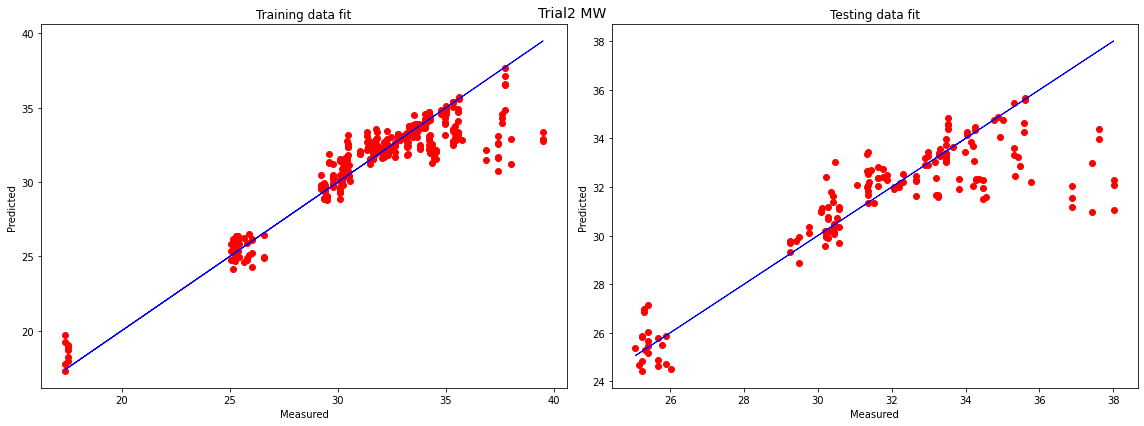

In [41]:
# fitting the model for grid search
#Trial 2 Moving Window
print("Trial 2")
print("PRE PROCESSING STEP: Moving Window Smoothing")
#input to base line removal is input array
with tf.device('/device:GPU:0'):
  preprocessed_spectra = pd.DataFrame(smooth_fast(spectra, 19, cols), columns=cols)
  data,_ = svm(preprocessed_spectra, y, 'Trial2','MW')
  result_df = result_df.append(data, ignore_index=True)

Trial 3
PRE PROCESSING STEP: Savitzky Golay Smoothing


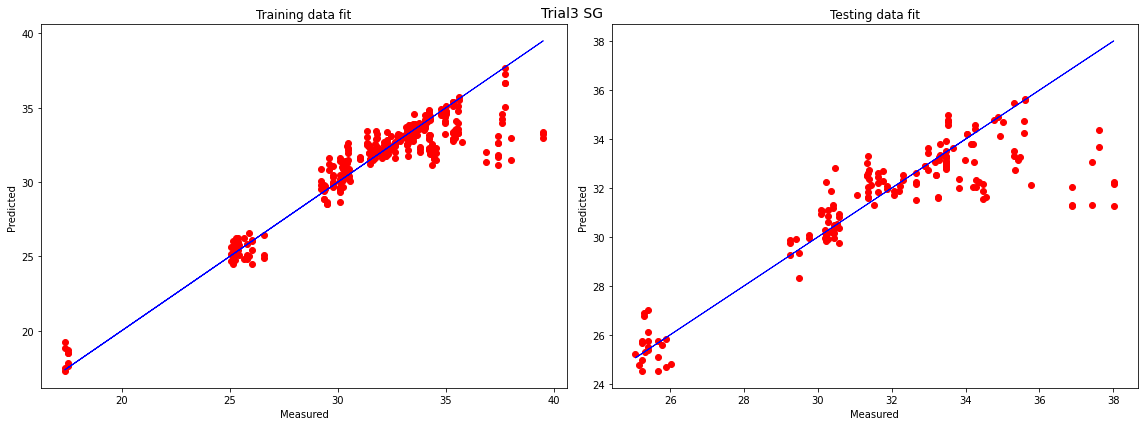

In [42]:
#Trial 3 Savitzky Golay smoothing
print("Trial 3")
print("PRE PROCESSING STEP: Savitzky Golay Smoothing")
#Using the same window size as in moving window smoothing
with tf.device('/device:GPU:0'):
    preprocessed_spectra = pd.DataFrame(savitzky(spectra, 19), columns=cols)
    data,_ = svm(preprocessed_spectra, y, 'Trial3','SG')
    result_df = result_df.append(data, ignore_index=True)

Trial 4
PRE PROCESSING STEP: Standard Normal Variate


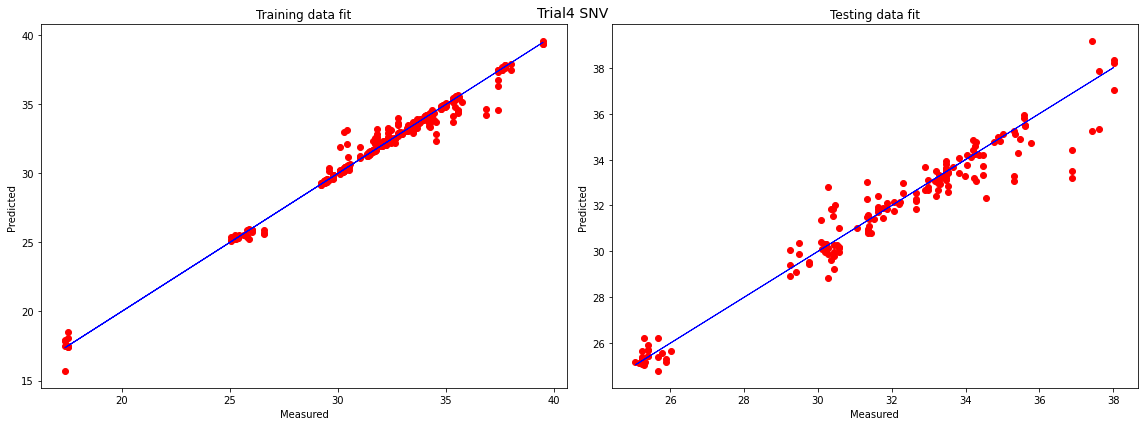

In [43]:
#Trial 4 SNV
print("Trial 4")
print("PRE PROCESSING STEP: Standard Normal Variate")
#input for SNV is an input array
with tf.device('/device:GPU:0'):
  preprocessed_spectra = pd.DataFrame(SNV(spectra), columns=cols)
  data,_ = svm(preprocessed_spectra, y, 'Trial4','SNV')
  result_df = result_df.append(data, ignore_index=True)

Trial 5
PRE PROCESSING STEP: Multiplicative Scatter Correction


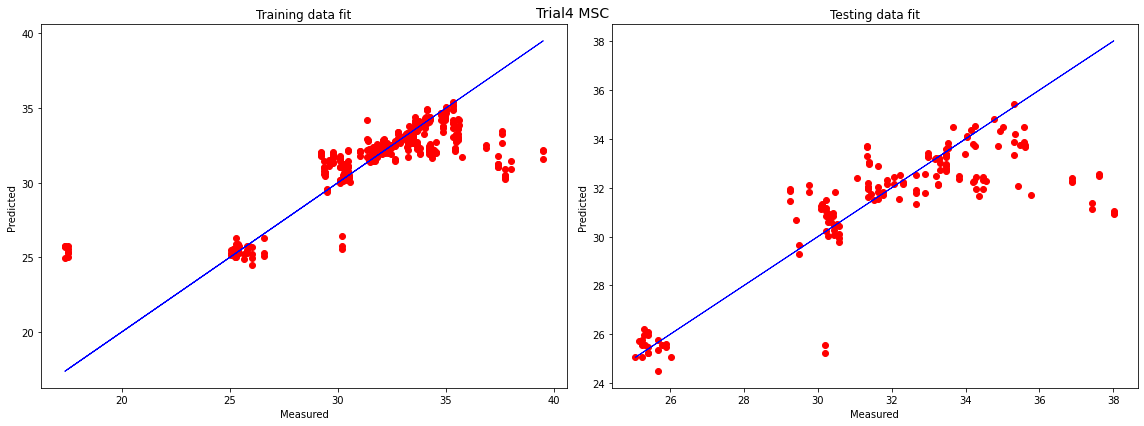

In [44]:
#Trial 5 Multiplicative Scatter Correction
#Input for MSC is an array
print("Trial 5")
print("PRE PROCESSING STEP: Multiplicative Scatter Correction")
with tf.device('/device:GPU:0'):
  preprocessed_spectra = pd.DataFrame(msc(spectra), columns=cols)
  data,_ = svm(preprocessed_spectra, y, 'Trial4','MSC')
  result_df = result_df.append(data, ignore_index=True)

Trial 6
PRE PROCESSING STEP: De-Trending


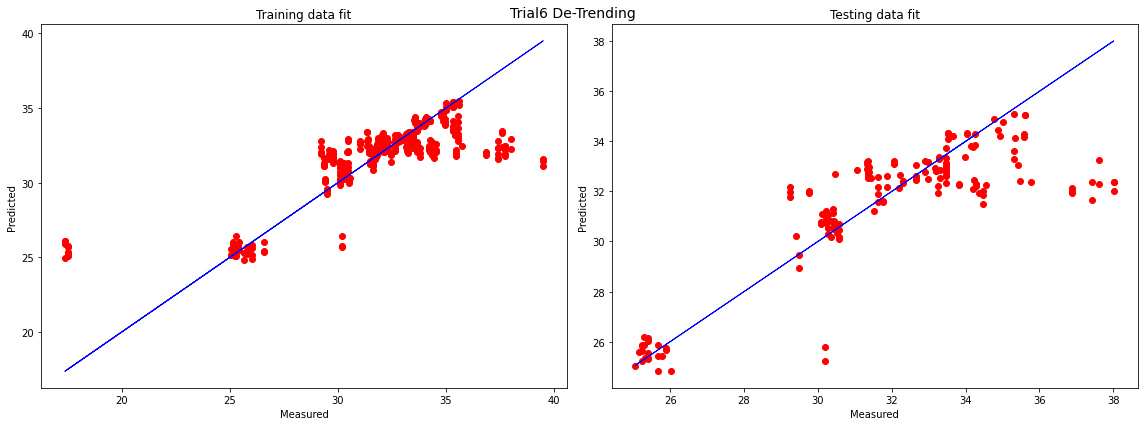

In [45]:
#Trial 6 De-Trending
print("Trial 6")
print("PRE PROCESSING STEP: De-Trending")
#input to base line removal is input array
with tf.device('/device:GPU:0'):
  preprocessed_spectra = pd.DataFrame(baseline(spectra, wave_length), columns=cols)
  data,_ = svm(preprocessed_spectra, y, 'Trial6','De-Trending')
  result_df = result_df.append(data, ignore_index=True)

Trial 7
PRE PROCESSING STEP: First Order Derivative


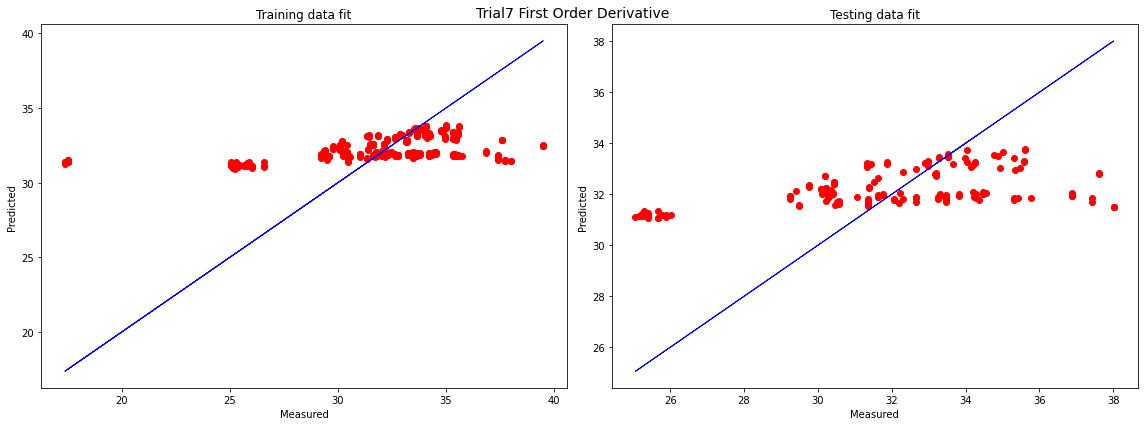

In [46]:
#Trial 7 Frist Order Derivative
#Input for derivative is an array
print("Trial 7")
print("PRE PROCESSING STEP: First Order Derivative")
#window length is 19 same as that for moving window smoothing
with tf.device('/device:GPU:0'):
  preprocessed_spectra = pd.DataFrame(derivate_first(spectra, 19), columns=wave_length)
  data,_ = svm(preprocessed_spectra, y, 'Trial7','First Order Derivative')
  result_df = result_df.append(data, ignore_index=True)

Trial 8
PRE PROCESSING STEP: Second Order Derivative


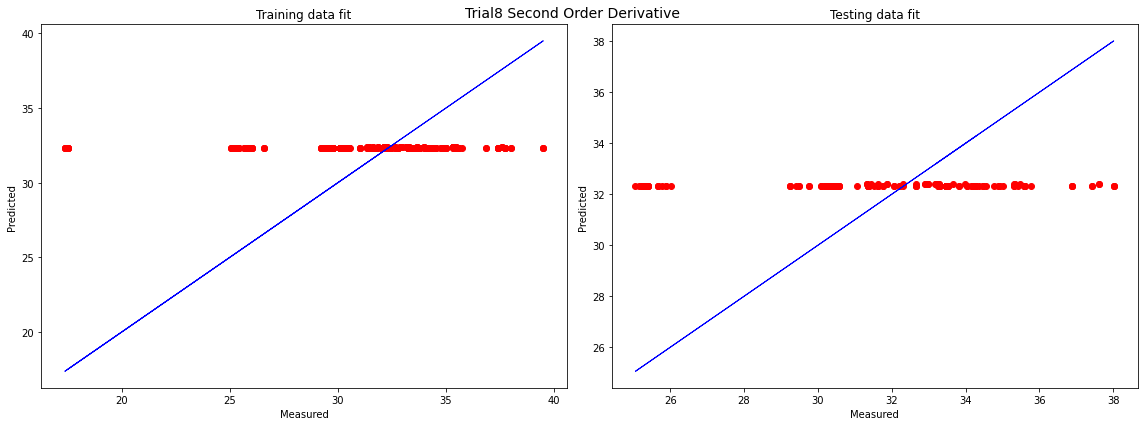

In [47]:
#Trial 8 Second Order Derivative
#Input for derivative is an array
print("Trial 8")
print("PRE PROCESSING STEP: Second Order Derivative")
#window length is 19 same as that for moving window smoothing
with tf.device('/device:GPU:0'):
  preprocessed_spectra = pd.DataFrame(derivate_second(spectra, 19), columns=wave_length)
  data,_ = svm(preprocessed_spectra, y, 'Trial8','Second Order Derivative')
  result_df = result_df.append(data, ignore_index=True)

Trial 9
PRE PROCESSING STEP: Moving window and SNV


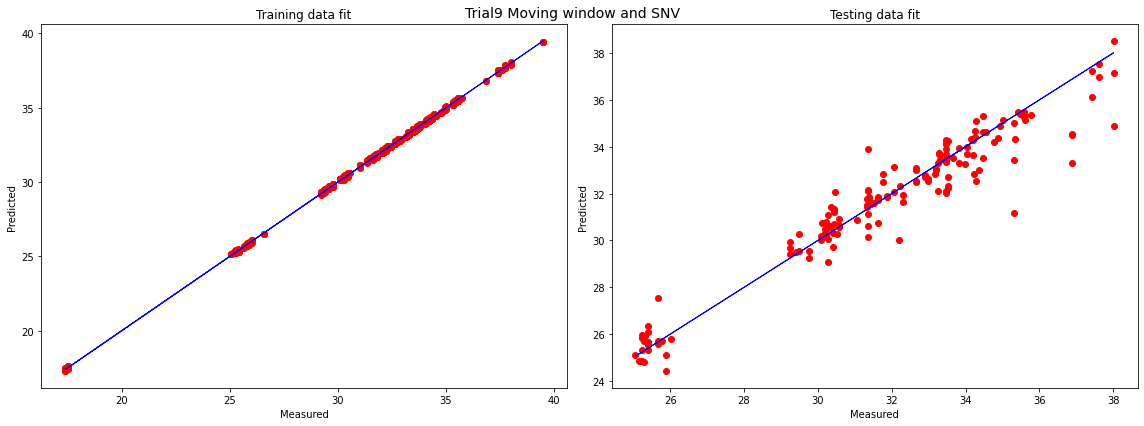

In [48]:
#Trial 9 Moving window , SNV
#Input for derivative is an array
print("Trial 9")
print("PRE PROCESSING STEP: Moving window and SNV")
#window length is 19 same as that for moving window smoothing
with tf.device('/device:GPU:0'):
  preprocessed_spectra = pd.DataFrame(SNV(smooth_fast(spectra, 19, cols)), columns=wave_length)
  data,_ = svm(preprocessed_spectra, y, 'Trial9','Moving window and SNV')
  result_df = result_df.append(data, ignore_index=True)

Trial 10
PRE PROCESSING STEP: Moving window and MSC


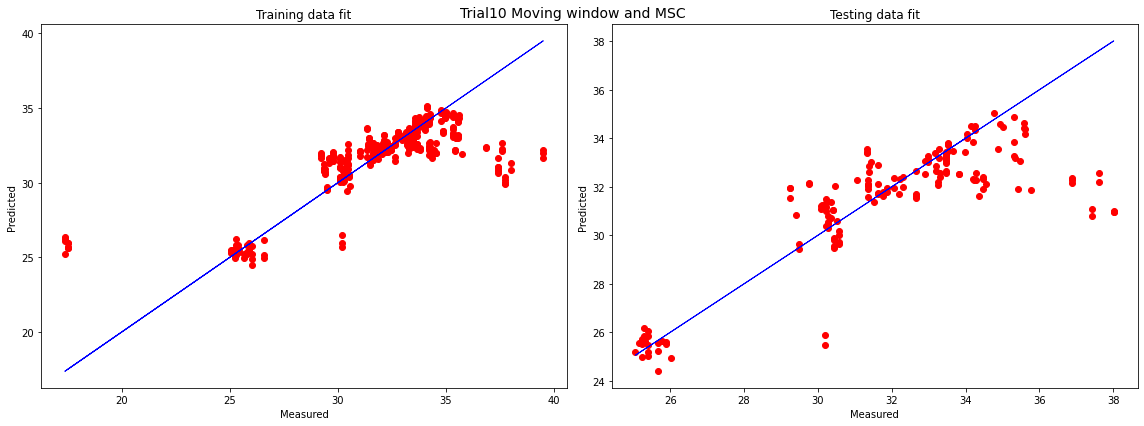

In [49]:
#Trial 10 Moving window , MSC
#Input for derivative is an array
print("Trial 10")
print("PRE PROCESSING STEP: Moving window and MSC")
#window length is 19 same as that for moving window smoothing
with tf.device('/device:GPU:0'):
  preprocessed_spectra = pd.DataFrame(msc(smooth_fast(spectra, 19, cols)), columns=cols)
  data,_ = svm(preprocessed_spectra, y, 'Trial10','Moving window and MSC')
  result_df = result_df.append(data, ignore_index=True)

Trial 11
PRE PROCESSING STEP: Moving window and De-Trending


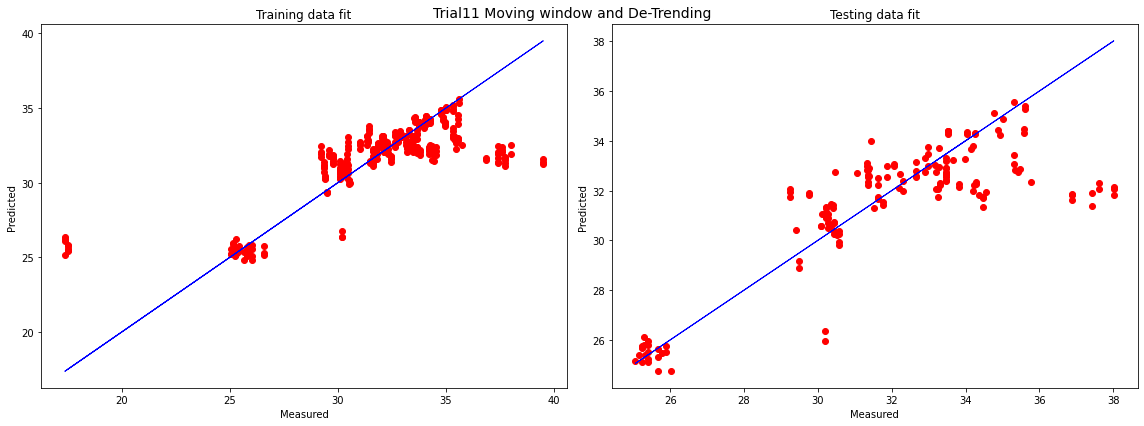

In [50]:
#Trial 11 Moving window , De-Trending
#Input for derivative is an array
print("Trial 11")
print("PRE PROCESSING STEP: Moving window and De-Trending")
#window length is 19 same as that for moving window smoothing
with tf.device('/device:GPU:0'):
  preprocessed_spectra = pd.DataFrame(baseline(smooth_fast(spectra, 19, cols), wave_length), columns=cols)
  data,_ = svm(preprocessed_spectra, y, 'Trial11','Moving window and De-Trending')
  result_df = result_df.append(data, ignore_index=True)

Trial 12
PRE PROCESSING STEP: Moving window and 1st order Derivative


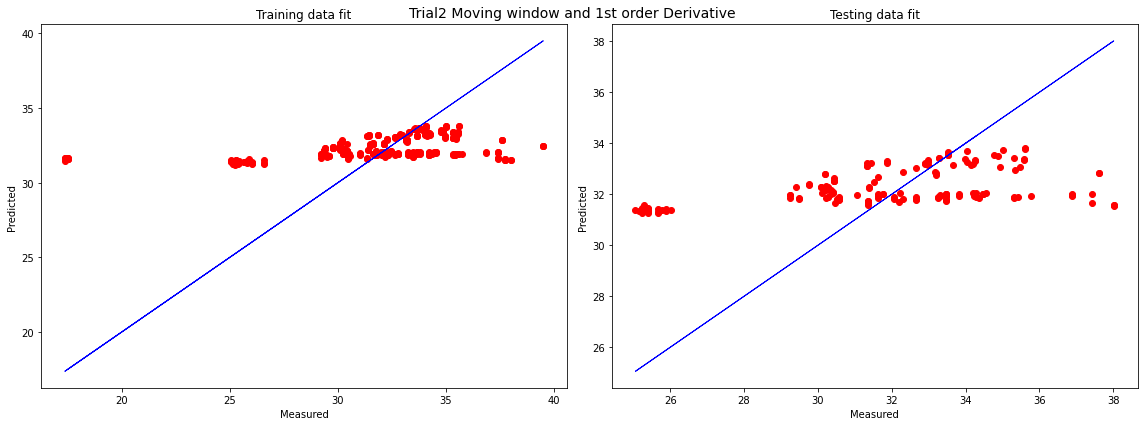

In [51]:
#Trial 12 Moving window , First ORder Derivative
#Input for derivative is an array
print("Trial 12")
print("PRE PROCESSING STEP: Moving window and 1st order Derivative")
#window length is 19 same as that for moving window smoothing
with tf.device('/device:GPU:0'):
  preprocessed_spectra = pd.DataFrame(derivate_first(smooth_fast(spectra, 19, cols), 19), columns=cols)
  data,_ = svm(preprocessed_spectra, y, 'Trial2','Moving window and 1st order Derivative')
  result_df = result_df.append(data, ignore_index=True)

Trial 13
PRE PROCESSING STEP: Moving window and 2nd order Derivative


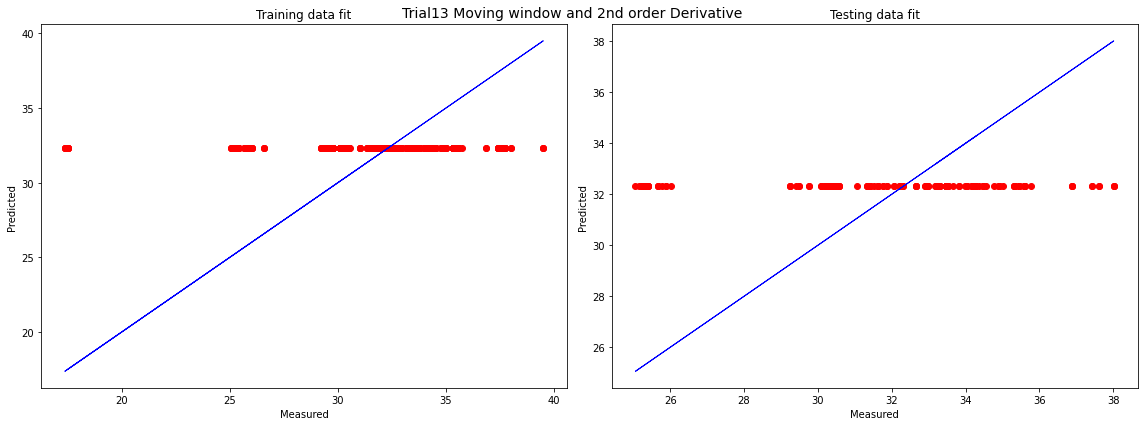

In [52]:
#Trial 13 Moving window , Derivative
#Input for derivative is an array
print("Trial 13")
print("PRE PROCESSING STEP: Moving window and 2nd order Derivative")
#window length is 19 same as that for moving window smoothing
with tf.device('/device:GPU:0'):
  preprocessed_spectra = pd.DataFrame(derivate_second(smooth_fast(spectra, 19, cols), 19), columns=cols)
  data,_ = svm(preprocessed_spectra, y, 'Trial13','Moving window and 2nd order Derivative')
  result_df = result_df.append(data, ignore_index=True)

Trial 14
PRE PROCESSING STEP: Savitzky Golay smoothing and SNV


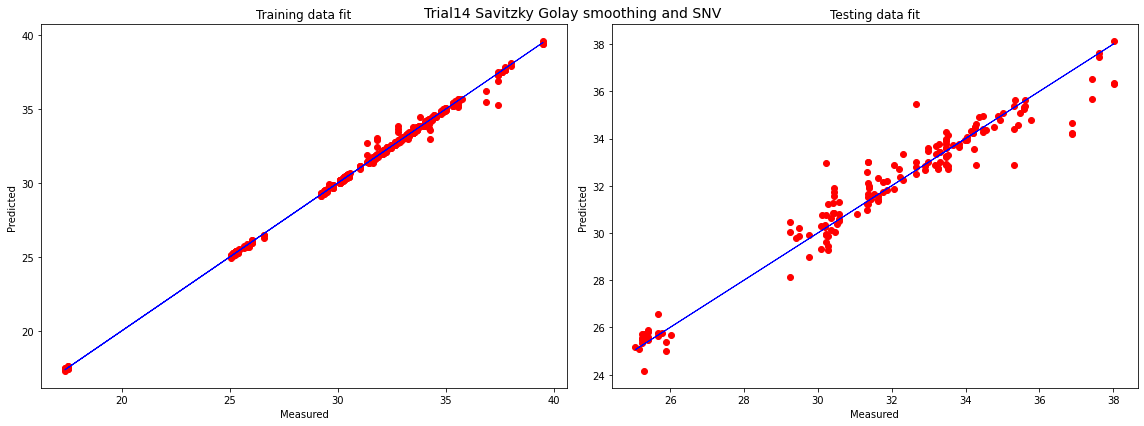

In [53]:
#Trial 14 Savtizky Golay , SNV
#
print("Trial 14")
print("PRE PROCESSING STEP: Savitzky Golay smoothing and SNV")
#window length is 19 same as that for moving window smoothing
with tf.device('/device:GPU:0'):
  preprocessed_spectra = pd.DataFrame(SNV(savitzky(spectra, 19)), columns=wave_length)
  data,_ = svm(preprocessed_spectra, y, 'Trial14','Savitzky Golay smoothing and SNV')
  result_df = result_df.append(data, ignore_index=True)

Trial 15
PRE PROCESSING STEP: Savitzky Golay smoothing and MSC


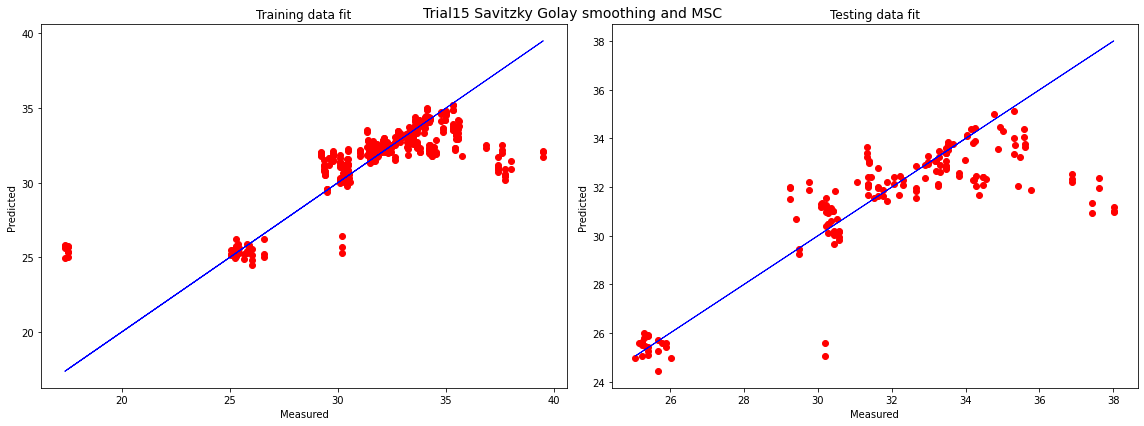

In [54]:
#Trial 15 Savtizky Golay , MSC
#
print("Trial 15")
print("PRE PROCESSING STEP: Savitzky Golay smoothing and MSC")
#window length is 19 same as that for moving window smoothing
with tf.device('/device:GPU:0'):
  preprocessed_spectra = pd.DataFrame(msc(savitzky(spectra, 19)), columns=wave_length)
  data,_ = svm(preprocessed_spectra, y, 'Trial15','Savitzky Golay smoothing and MSC')
  result_df = result_df.append(data, ignore_index=True)

Trial 16
PRE PROCESSING STEP: Savitzky Golay smoothing and baseline removal


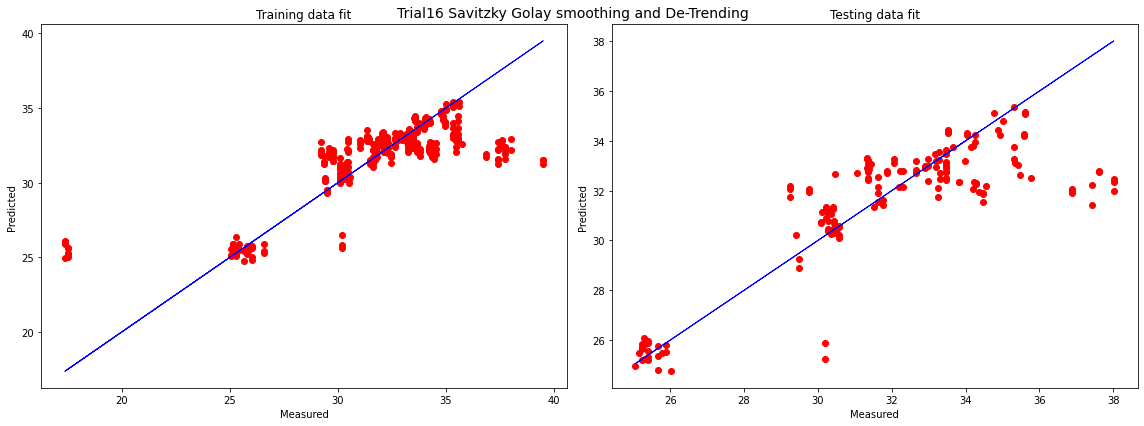

In [55]:
#Trial 16 Savtizky Golay , De-Trending
#
print("Trial 16")
print("PRE PROCESSING STEP: Savitzky Golay smoothing and baseline removal")
#window length is 19 same as that for moving window smoothing
with tf.device('/device:GPU:0'):
  preprocessed_spectra = pd.DataFrame(baseline(savitzky(spectra, 19), wave_length), columns=wave_length)
  data,_ = svm(preprocessed_spectra, y, 'Trial16','Savitzky Golay smoothing and De-Trending')
  result_df = result_df.append(data, ignore_index=True)

Trial 17
PRE PROCESSING STEP: Savitzky Golay smoothing and 1st order Derivative


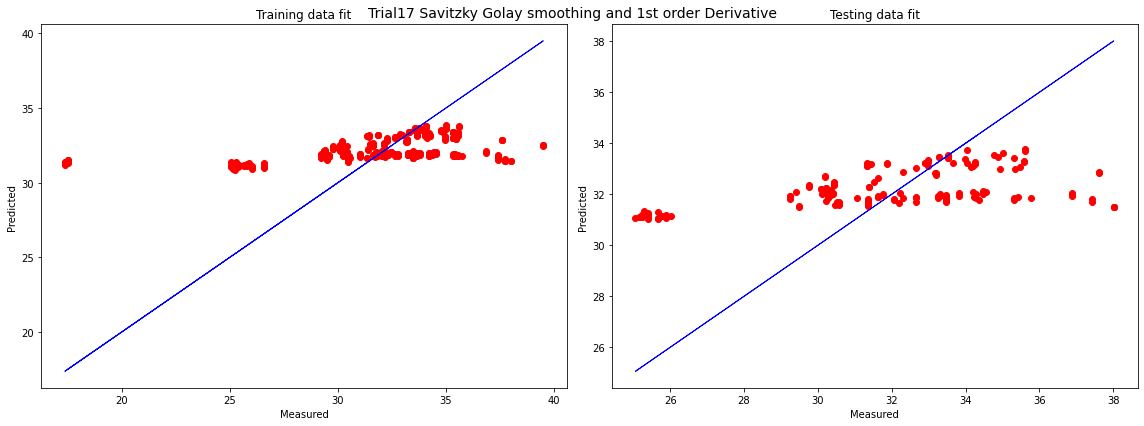

In [56]:
#Trial 17 Savtizky Golay , 1st order Derivative
#
print("Trial 17")
print("PRE PROCESSING STEP: Savitzky Golay smoothing and 1st order Derivative")
#window length is 19 same as that for moving window smoothing
with tf.device('/device:GPU:0'):
  preprocessed_spectra = pd.DataFrame(derivate_first(savitzky(spectra, 19), 19), columns=wave_length)
  data,_ = svm(preprocessed_spectra, y, 'Trial17','Savitzky Golay smoothing and 1st order Derivative')
  result_df = result_df.append(data, ignore_index=True)

Trial 18
PRE PROCESSING STEP: Savitzky Golay smoothing and 2nd order Derivative


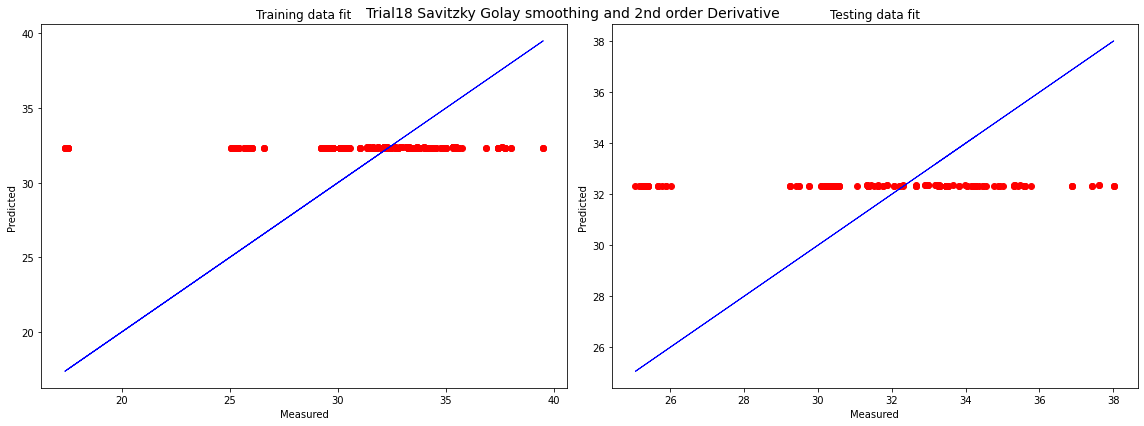

In [57]:
#Trial 18 Savtizky Golay , 2nd order Derivative
#
print("Trial 18")
print("PRE PROCESSING STEP: Savitzky Golay smoothing and 2nd order Derivative")
#window length is 19 same as that for moving window smoothing
with tf.device('/device:GPU:0'):
  preprocessed_spectra = pd.DataFrame(derivate_second(savitzky(spectra, 19), 19), columns=wave_length)
  data,_ = svm(preprocessed_spectra, y, 'Trial18','Savitzky Golay smoothing and 2nd order Derivative')
  result_df = result_df.append(data, ignore_index=True)

Trial 19
PRE PROCESSING STEP: Moving window , SNV and MSC


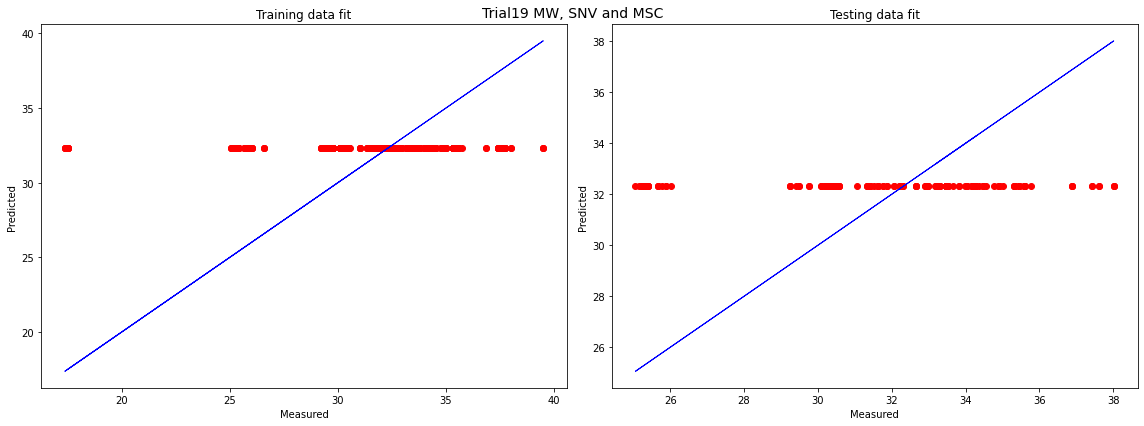

In [58]:
#Trial 19 Moving window , SNV and MSC
#Input for derivative is an array
print("Trial 19")
print("PRE PROCESSING STEP: Moving window , SNV and MSC")
#window length is 19 same as that for moving window smoothing
with tf.device('/device:GPU:0'):
  preprocessed_spectra = pd.DataFrame(msc(SNV(smooth_fast(spectra, 19, cols))), columns=wave_length)
  data,_ = svm(preprocessed_spectra, y, 'Trial19','MW, SNV and MSC')
  result_df = result_df.append(data, ignore_index=True)

Trial 20
PRE PROCESSING STEP: Moving window , SNV and De-Trending


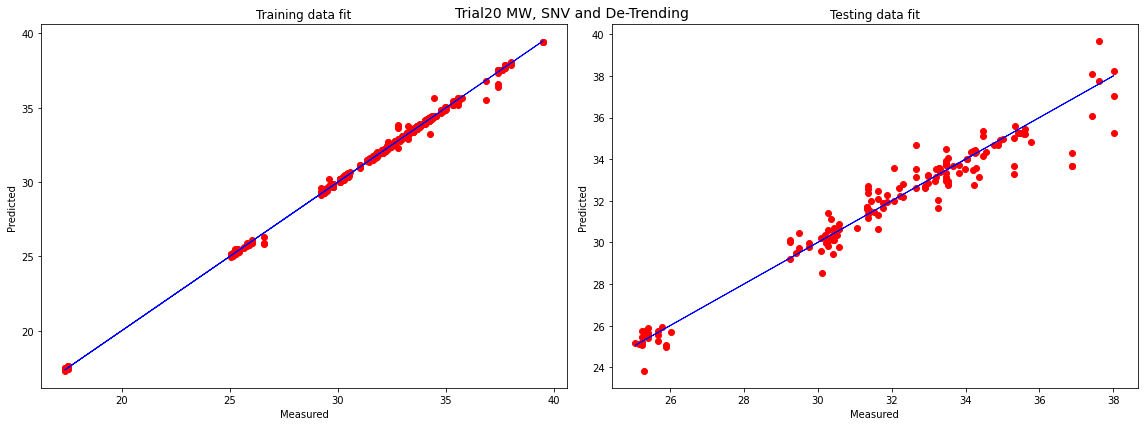

In [59]:
#Trial 20 Moving window , SNV and De-Trending
#Input for derivative is an array
print("Trial 20")
print("PRE PROCESSING STEP: Moving window , SNV and De-Trending")
#window length is 19 same as that for moving window smoothing
with tf.device('/device:GPU:0'):
  preprocessed_spectra = pd.DataFrame(baseline(SNV(smooth_fast(spectra, 19, cols)), wave_length), columns=cols)
  data,_ = svm(preprocessed_spectra, y, 'Trial20','MW, SNV and De-Trending')
  result_df = result_df.append(data, ignore_index=True)

Trial 21
PRE PROCESSING STEP: Moving window , SNV and 1st order Derivative


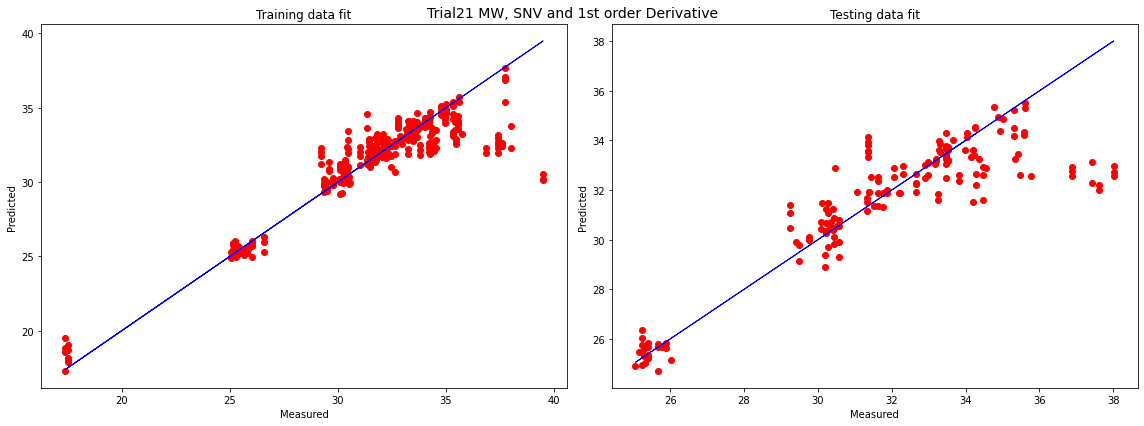

In [60]:
#Trial 21 Moving window , SNV and 1st order Derivative
#Input for derivative is an array
print("Trial 21")
print("PRE PROCESSING STEP: Moving window , SNV and 1st order Derivative")
#window length is 19 same as that for moving window smoothing
with tf.device('/device:GPU:0'):
  preprocessed_spectra = pd.DataFrame(derivate_first(SNV(smooth_fast(spectra, 19, cols)), 19), columns=cols)
  data,_ = svm(preprocessed_spectra, y, 'Trial21','MW, SNV and 1st order Derivative')
  result_df = result_df.append(data, ignore_index=True)

Trial 22
PRE PROCESSING STEP: Moving window , SNV and 2nd order Derivative


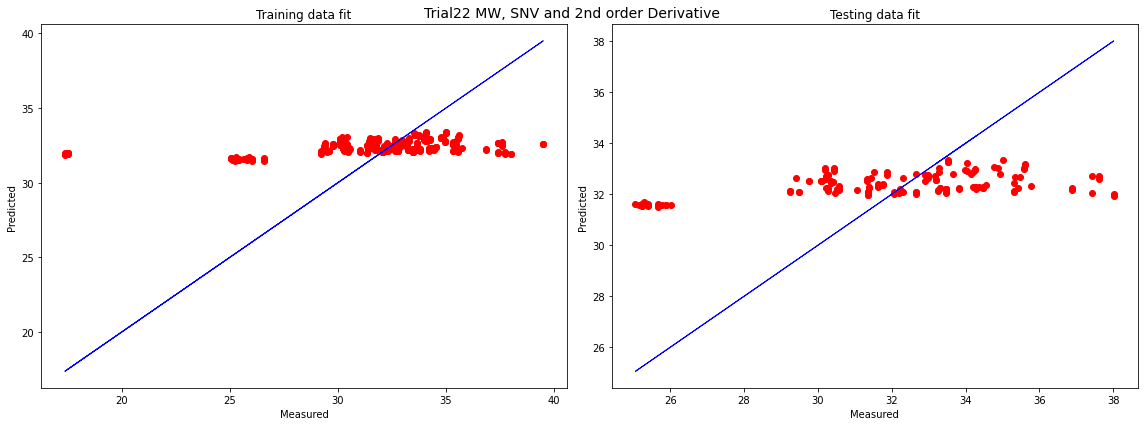

In [61]:
#Trial 22 Moving window , SNV and 2nd order Derivative
#Input for derivative is an array
print("Trial 22")
print("PRE PROCESSING STEP: Moving window , SNV and 2nd order Derivative")
#window length is 19 same as that for moving window smoothing
with tf.device('/device:GPU:0'):
  preprocessed_spectra = pd.DataFrame(derivate_second(SNV(smooth_fast(spectra, 19, cols)), 19), columns=cols)
  data,_ = svm(preprocessed_spectra, y, 'Trial22','MW, SNV and 2nd order Derivative')
  result_df = result_df.append(data, ignore_index=True)

Trial 23
PRE PROCESSING STEP: Moving window , MSC and De-Trending


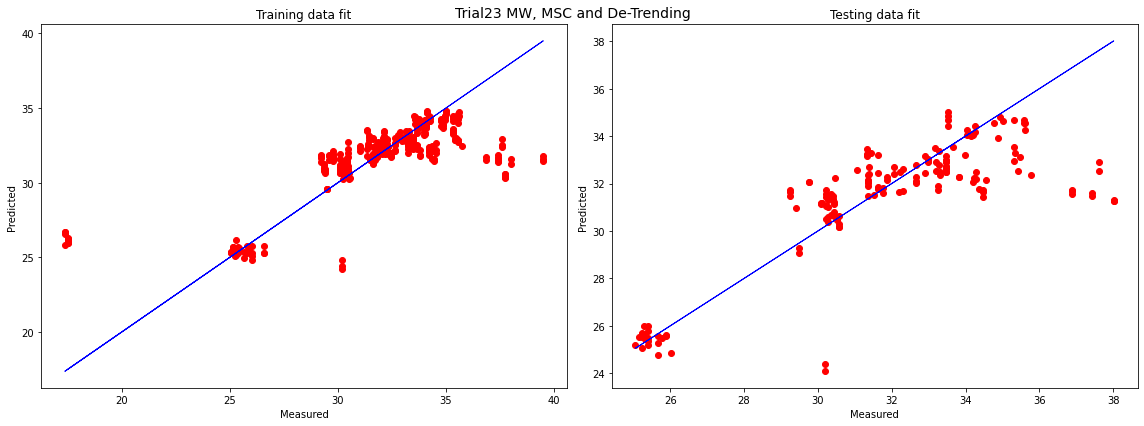

In [62]:
#Trial 23 Moving window , MSC and De-Trending
#Input for derivative is an array
print("Trial 23")
print("PRE PROCESSING STEP: Moving window , MSC and De-Trending")
#window length is 19 same as that for moving window smoothing
with tf.device('/device:GPU:0'):
  preprocessed_spectra = pd.DataFrame(baseline(msc(smooth_fast(spectra, 19, cols)), wave_length), columns=cols)
  data,_ = svm(preprocessed_spectra, y, 'Trial23','MW, MSC and De-Trending')
  result_df = result_df.append(data, ignore_index=True)

Trial 24
PRE PROCESSING STEP: Moving window , SNV and 1st order Derivative


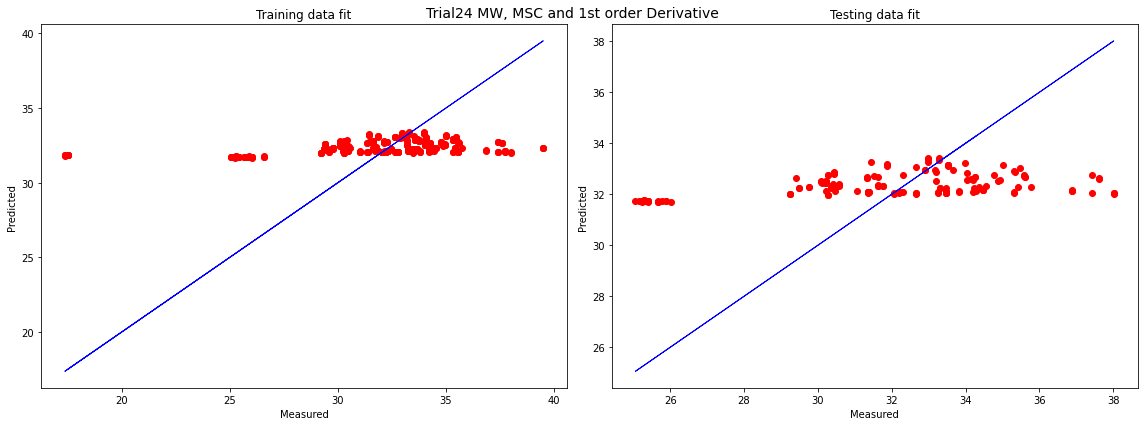

In [63]:
#Trial 24 Moving window , SNV and 1st order Derivative
#Input for derivative is an array
print("Trial 24")
print("PRE PROCESSING STEP: Moving window , SNV and 1st order Derivative")
#window length is 19 same as that for moving window smoothing
with tf.device('/device:GPU:0'):
  preprocessed_spectra = pd.DataFrame(derivate_first(msc(smooth_fast(spectra, 19, cols)), 19), columns=cols)
  data ,_= svm(preprocessed_spectra, y, 'Trial24','MW, MSC and 1st order Derivative')
  result_df = result_df.append(data, ignore_index=True)

Trial 25
PRE PROCESSING STEP: Moving window , MSC and 2nd order Derivative


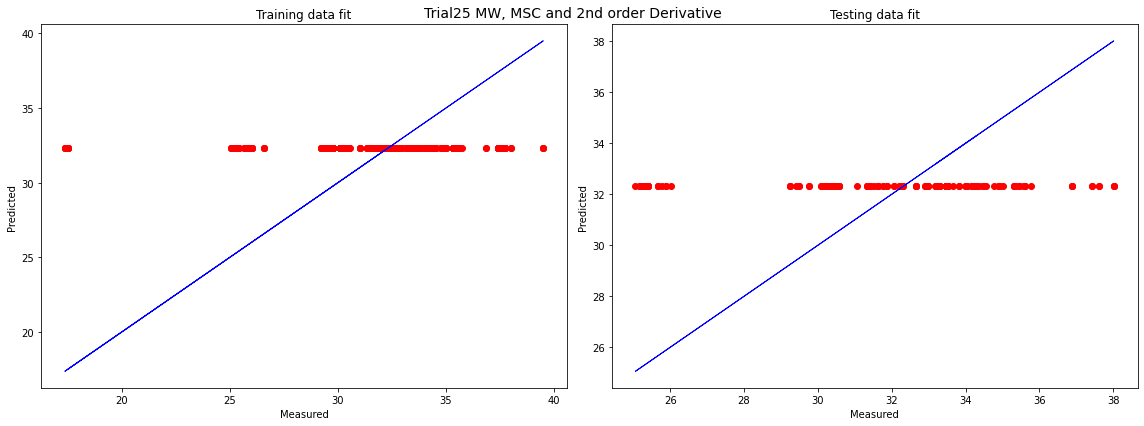

In [64]:
#Trial 25 Moving window , MSC and 2nd order Derivative
#Input for derivative is an array
print("Trial 25")
print("PRE PROCESSING STEP: Moving window , MSC and 2nd order Derivative")
#window length is 19 same as that for moving window smoothing
with tf.device('/device:GPU:0'):
  preprocessed_spectra = pd.DataFrame(derivate_second(msc(smooth_fast(spectra, 19, cols)), 19), columns=cols)
  data,_ = svm(preprocessed_spectra, y, 'Trial25','MW, MSC and 2nd order Derivative')
  result_df = result_df.append(data, ignore_index=True)

Trial 26
PRE PROCESSING STEP: Moving window , De-Trending and 1st order Derivative


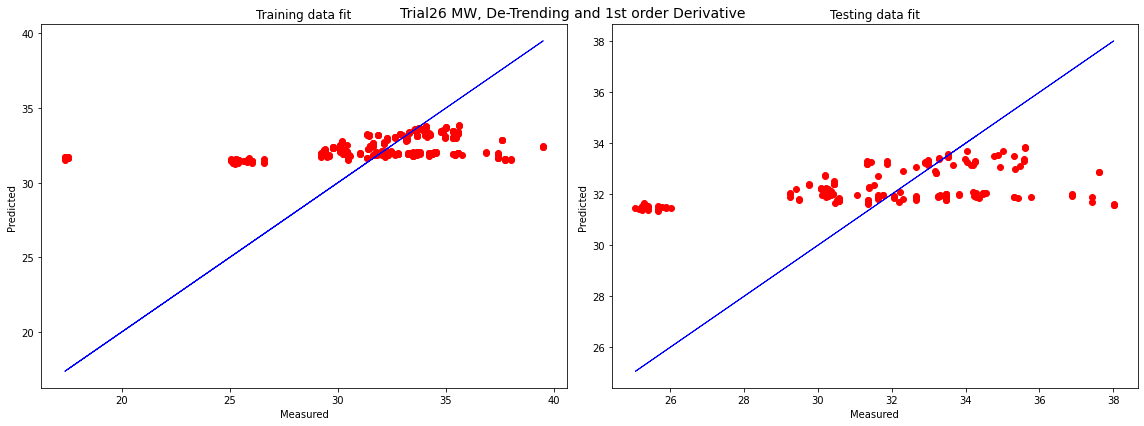

In [65]:
#Trial 26 Moving window , De-Trending and 1st order Derivative
#Input for derivative is an array
print("Trial 26")
print("PRE PROCESSING STEP: Moving window , De-Trending and 1st order Derivative")
#window length is 19 same as that for moving window smoothing
with tf.device('/device:GPU:0'):
  preprocessed_spectra = pd.DataFrame(derivate_first(baseline(smooth_fast(spectra, 19, cols), wave_length), 19), columns=cols)
  data,_ = svm(preprocessed_spectra, y, 'Trial26','MW, De-Trending and 1st order Derivative')
  result_df = result_df.append(data, ignore_index=True)

Trial 27
PRE PROCESSING STEP: Moving window , De-Trending and 2nd order Derivative


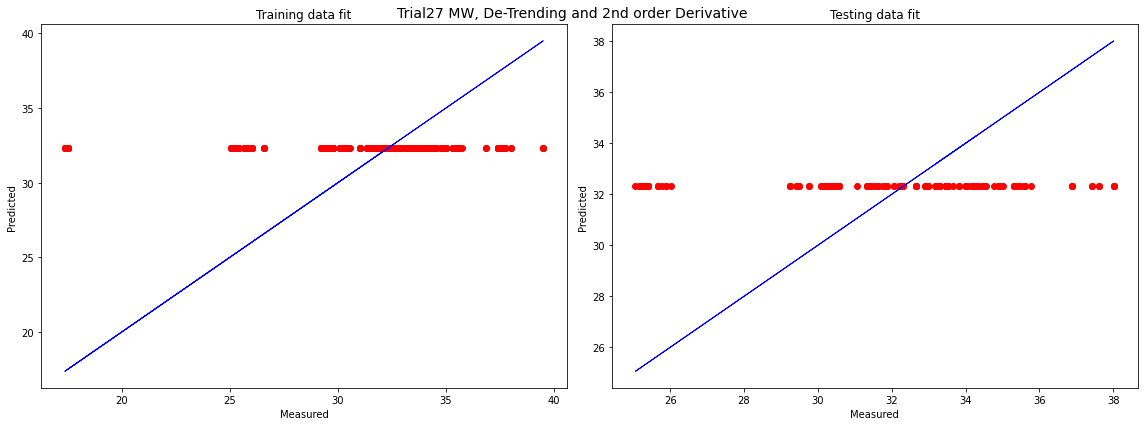

In [66]:
#Trial 27 Moving window , De-Trending and 2nd order Derivative
#Input for derivative is an array
print("Trial 27")
print("PRE PROCESSING STEP: Moving window , De-Trending and 2nd order Derivative")
#window length is 19 same as that for moving window smoothing
with tf.device('/device:GPU:0'):
  preprocessed_spectra = pd.DataFrame(derivate_second(baseline(smooth_fast(spectra, 19, cols), wave_length), 19), columns=cols)
  data,_ = svm(preprocessed_spectra, y, 'Trial27','MW, De-Trending and 2nd order Derivative')
  result_df = result_df.append(data, ignore_index=True)

Trial 28
PRE PROCESSING STEP: Moving window , 1st order Derivative and 2nd order Derivative


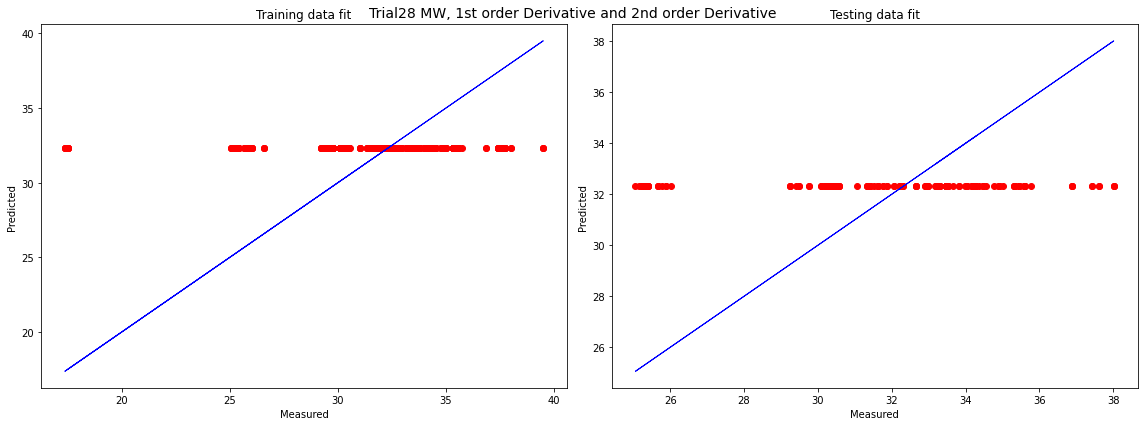

In [67]:
#Trial 28 Moving window , 1st order Derivative and 2nd order Derivative
#Input for derivative is an array
print("Trial 28")
print("PRE PROCESSING STEP: Moving window , 1st order Derivative and 2nd order Derivative")
#window length is 19 same as that for moving window smoothing
with tf.device('/device:GPU:0'):
  preprocessed_spectra = pd.DataFrame(derivate_second(derivate_first(smooth_fast(spectra, 19, cols), 19), 19), columns=cols)
  data,_ = svm(preprocessed_spectra, y, 'Trial28','MW, 1st order Derivative and 2nd order Derivative')
  result_df = result_df.append(data, ignore_index=True)

Trial 29
PRE PROCESSING STEP: Savitzky Golay smoothing, SNV and MSC


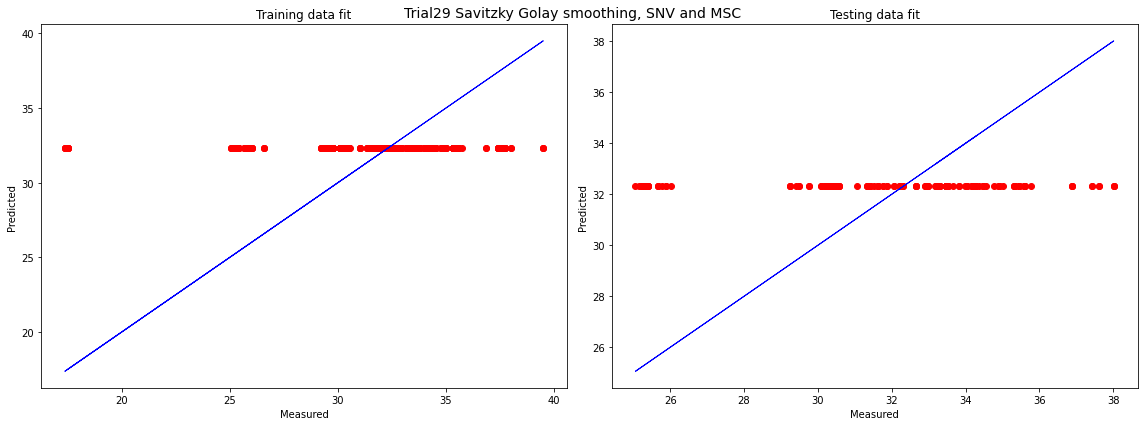

In [68]:
#Trial 29 Savtizky Golay , SNV and MSC
print("Trial 29")
print("PRE PROCESSING STEP: Savitzky Golay smoothing, SNV and MSC")
#window length is 19 same as that for moving window smoothing
with tf.device('/device:GPU:0'):
  preprocessed_spectra = pd.DataFrame(msc(SNV(savitzky(spectra, 19))), columns=cols)
  data,_ = svm(preprocessed_spectra, y, 'Trial29','Savitzky Golay smoothing, SNV and MSC')
  result_df = result_df.append(data, ignore_index=True)

Trial 30
PRE PROCESSING STEP: Savitzky Golay smoothing, SNV and De-Trending


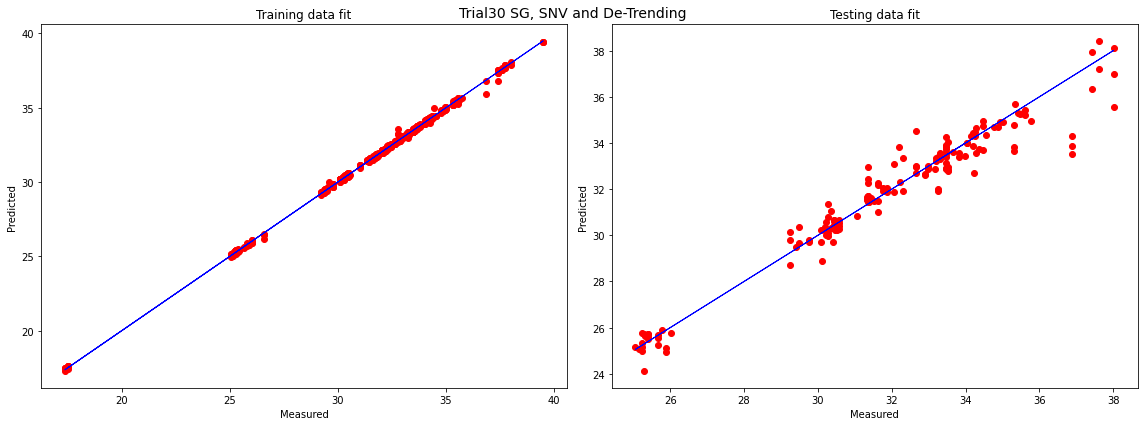

In [69]:
#Trial 30 Savtizky Golay , SNV and Baseline
print("Trial 30")
print("PRE PROCESSING STEP: Savitzky Golay smoothing, SNV and De-Trending")
#window length is 19 same as that for moving window smoothing
with tf.device('/device:GPU:0'):
  preprocessed_spectra = pd.DataFrame(baseline(SNV(savitzky(spectra, 19)), wave_length), columns=cols)
  data,model = svm(preprocessed_spectra, y, 'Trial30','SG, SNV and De-Trending')
  result_df = result_df.append(data, ignore_index=True)

In [70]:
result_df

,Trial No,Model,Pre Processing,Training R²,Validation R²,Best fit Hyperparameters
0,Trial1,SVM,None,0.863091,0.736992,"{'C': 1000, 'gamma': 1, 'kernel': 'rbf'}"
1,Trial2,SVM,MW,0.844231,0.720042,"{'C': 1000, 'gamma': 1, 'kernel': 'rbf'}"
2,Trial3,SVM,SG,0.854183,0.727512,"{'C': 1000, 'gamma': 1, 'kernel': 'rbf'}"
3,Trial4,SVM,SNV,0.983158,0.934418,"{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}"
4,Trial4,SVM,MSC,0.641341,0.651661,"{'C': 1000, 'gamma': 1, 'kernel': 'rbf'}"
5,Trial6,SVM,De-Trending,0.663369,0.688288,"{'C': 1000, 'gamma': 1, 'kernel': 'rbf'}"
6,Trial7,SVM,First Order Derivative,0.147153,0.175549,"{'C': 1000, 'gamma': 1, 'kernel': 'rbf'}"
7,Trial8,SVM,Second Order Derivative,-0.018212,-0.022041,"{'C': 1000, 'gamma': 1, 'kernel': 'rbf'}"
8,Trial9,SVM,Moving window and SNV,0.999389,0.924477,"{'C': 1000, 'gamma': 0.1, 'kernel': 'rbf'}"
9,Trial10,SVM,Moving window and MSC,0.611000,0.644230,"{'C': 1000, 'gamma': 1, 'kernel': 'rbf'}"


Trial 31
PRE PROCESSING STEP: Savitzky Golay smoothing, SNV and 1st order Derivative


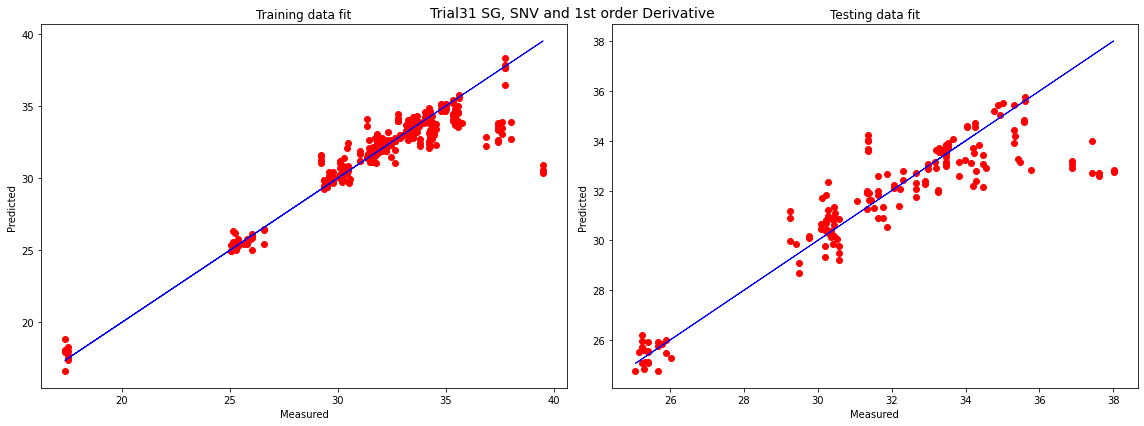

In [71]:
#Trial 31 Savtizky Golay , SNV and 1st order Derivative
print("Trial 31")
print("PRE PROCESSING STEP: Savitzky Golay smoothing, SNV and 1st order Derivative")
#window length is 19 same as that for moving window smoothing
with tf.device('/device:GPU:0'):
  preprocessed_spectra = pd.DataFrame(derivate_first(SNV(savitzky(spectra, 19)), 19), columns=cols)
  data,_ = svm(preprocessed_spectra, y, 'Trial31','SG, SNV and 1st order Derivative')
  result_df = result_df.append(data, ignore_index=True)

Trial 32
PRE PROCESSING STEP: Savitzky Golay smoothing, SNV and 2nd order Derivative


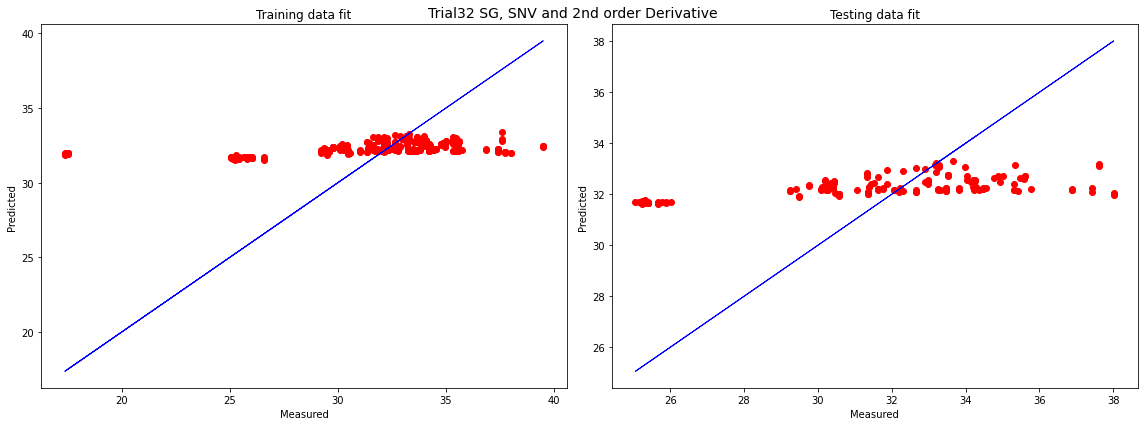

In [72]:
#Trial 32 Savtizky Golay , SNV and 2nd order Derivative
print("Trial 32")
print("PRE PROCESSING STEP: Savitzky Golay smoothing, SNV and 2nd order Derivative")
#window length is 19 same as that for moving window smoothing
with tf.device('/device:GPU:0'):
  preprocessed_spectra = pd.DataFrame(derivate_second(SNV(savitzky(spectra, 19)), 19), columns=cols)
  data,_ = svm(preprocessed_spectra, y, 'Trial32','SG, SNV and 2nd order Derivative')
  result_df = result_df.append(data, ignore_index=True)

Trial 33
PRE PROCESSING STEP: Savitzky Golay smoothing, MSC and De-Trending


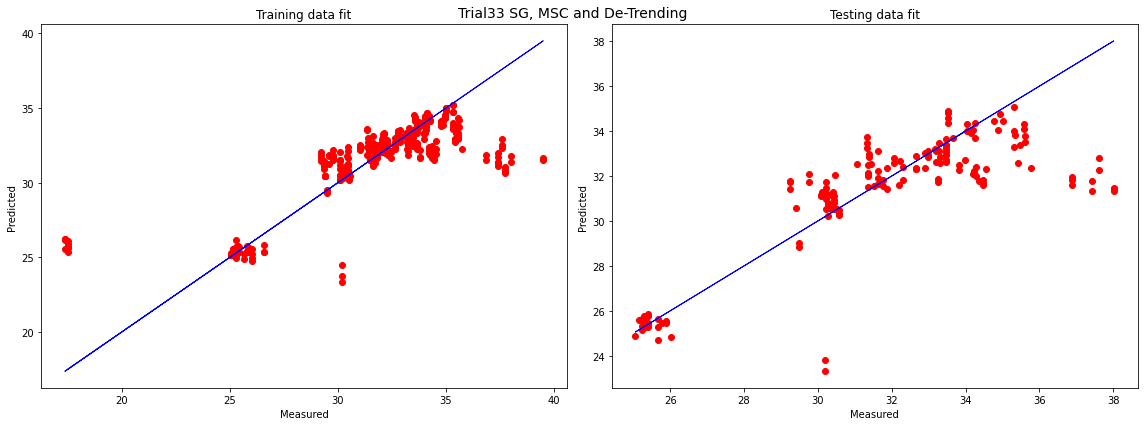

In [73]:
#Trial 33 Savtizky Golay , MSC and De-Trending
print("Trial 33")
print("PRE PROCESSING STEP: Savitzky Golay smoothing, MSC and De-Trending")
#window length is 19 same as that for moving window smoothing
with tf.device('/device:GPU:0'):
  preprocessed_spectra = pd.DataFrame(baseline(msc(savitzky(spectra, 19)), wave_length), columns=cols)
  data,_ = svm(preprocessed_spectra, y, 'Trial33','SG, MSC and De-Trending')
  result_df = result_df.append(data, ignore_index=True)

Trial 34
PRE PROCESSING STEP: Savitzky Golay smoothing, MSC and 1st order Derivative


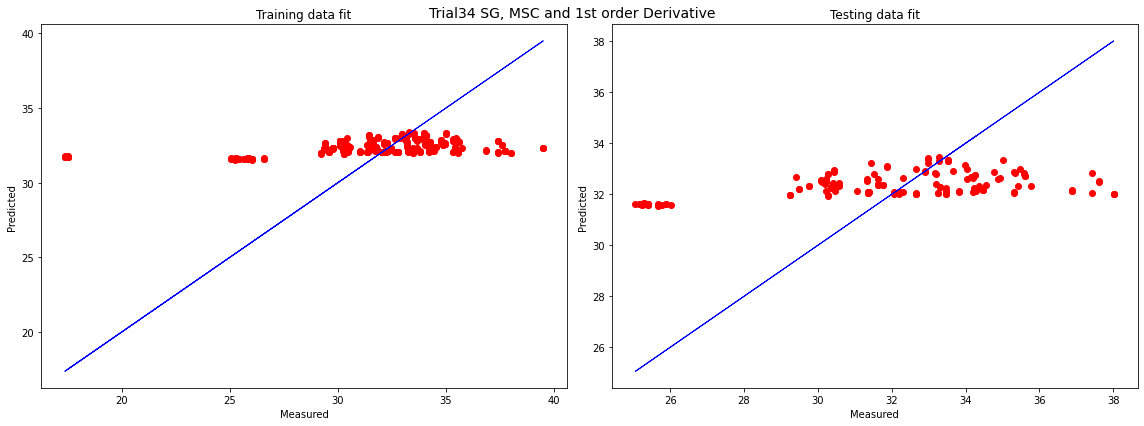

In [74]:
#Trial 34 Savtizky Golay , SNV and 1st order Derivative
print("Trial 34")
print("PRE PROCESSING STEP: Savitzky Golay smoothing, MSC and 1st order Derivative")
#window length is 19 same as that for moving window smoothing
with tf.device('/device:GPU:0'):
  preprocessed_spectra = pd.DataFrame(derivate_first(msc(savitzky(spectra, 19)), 19), columns=cols)
  data,_ = svm(preprocessed_spectra, y, 'Trial34','SG, MSC and 1st order Derivative')
  result_df = result_df.append(data, ignore_index=True)

Trial 35
PRE PROCESSING STEP: Savitzky Golay smoothing, MSC and 2nd order Derivative


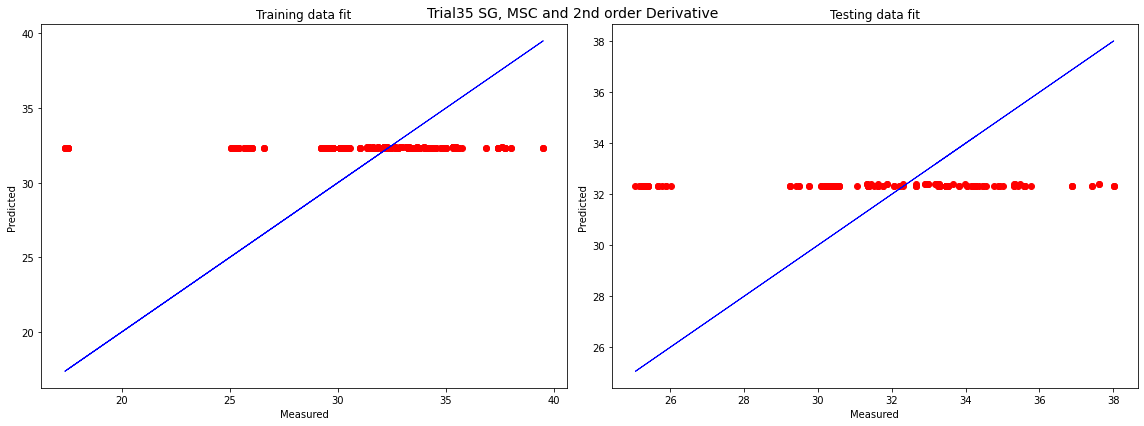

In [75]:
#Trial 35 Savtizky Golay , SNV and 2nd order Derivative
print("Trial 35")
print("PRE PROCESSING STEP: Savitzky Golay smoothing, MSC and 2nd order Derivative")
#window length is 19 same as that for moving window smoothing
with tf.device('/device:GPU:0'):
  preprocessed_spectra = pd.DataFrame(derivate_second(msc(savitzky(spectra, 19)), 19), columns=cols)
  data,_= svm(preprocessed_spectra, y, 'Trial35','SG, MSC and 2nd order Derivative')
  result_df = result_df.append(data, ignore_index=True)

Trial 36
PRE PROCESSING STEP: Savitzky Golay smoothing, De-Trending and 1st order Derivative


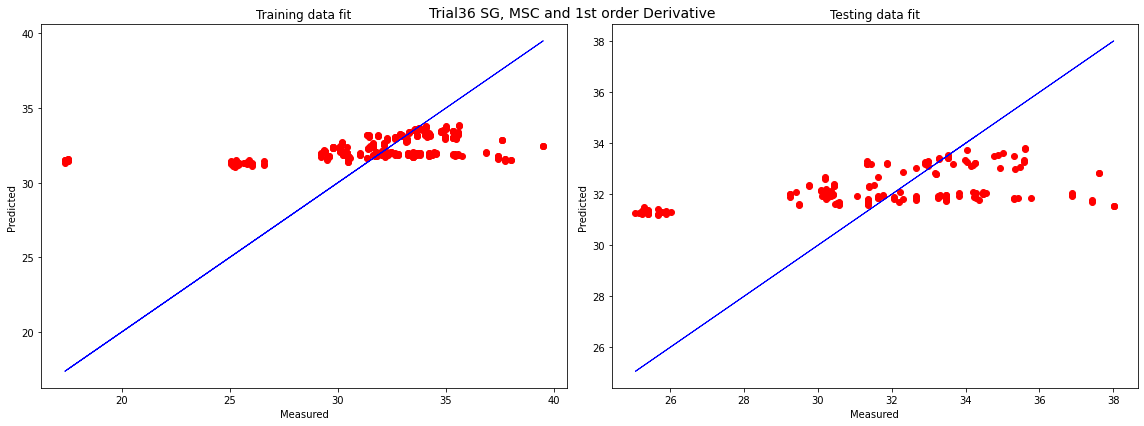

In [76]:
#Trial 36 Savtizky Golay , De-Trending and 1st order Derivative
print("Trial 36")
print("PRE PROCESSING STEP: Savitzky Golay smoothing, De-Trending and 1st order Derivative")
#window length is 19 same as that for moving window smoothing
with tf.device('/device:GPU:0'):
  preprocessed_spectra = pd.DataFrame(derivate_first(baseline(savitzky(spectra, 19), wave_length), 19), columns=cols)
  data,_ = svm(preprocessed_spectra, y, 'Trial36','SG, MSC and 1st order Derivative')
  result_df = result_df.append(data, ignore_index=True)

Trial 37
PRE PROCESSING STEP: Savitzky Golay smoothing, De-Trending and 2nd order Derivative


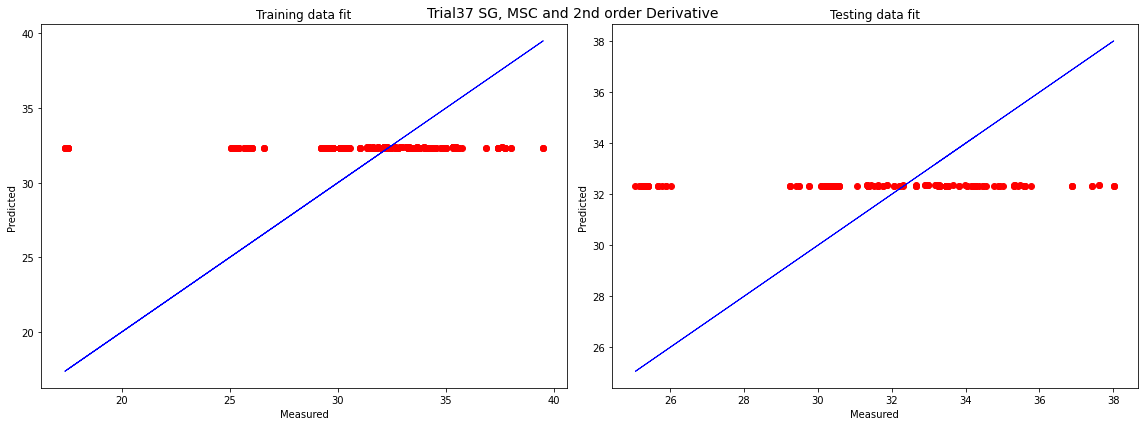

In [77]:
#Trial 37 Savtizky Golay , De-Trending and 1st order Derivative
print("Trial 37")
print("PRE PROCESSING STEP: Savitzky Golay smoothing, De-Trending and 2nd order Derivative")
#window length is 19 same as that for moving window smoothing
with tf.device('/device:GPU:0'):
  preprocessed_spectra = pd.DataFrame(derivate_second(baseline(savitzky(spectra, 19), wave_length), 19), columns=cols)
  data,_ = svm(preprocessed_spectra, y, 'Trial37','SG, MSC and 2nd order Derivative')
  result_df = result_df.append(data, ignore_index=True)

Trial 38
PRE PROCESSING STEP: Moving window , SNV, De-Trending and MSC


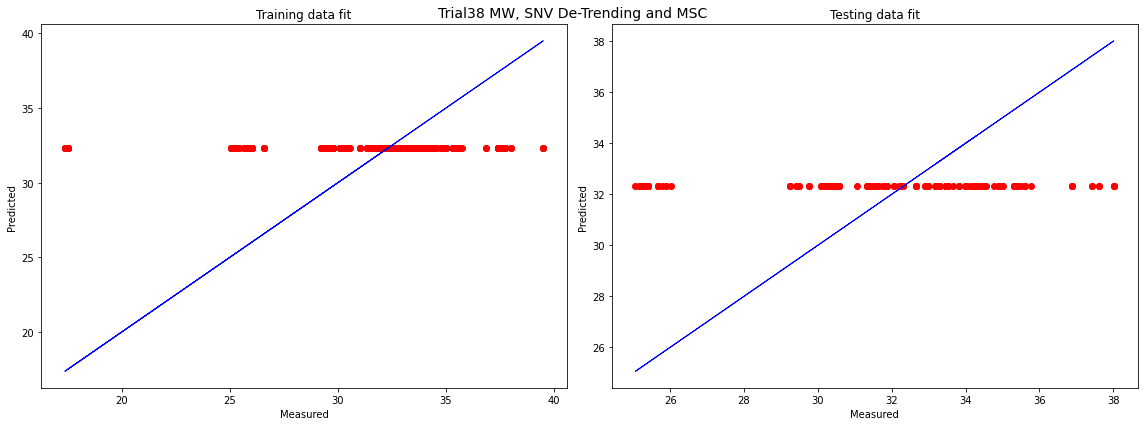

In [78]:
#Trial 38 Moving window , SNV and De-Trending, MSC
#Input for derivative is an array
print("Trial 38")
print("PRE PROCESSING STEP: Moving window , SNV, De-Trending and MSC")
#window length is 19 same as that for moving window smoothing
with tf.device('/device:GPU:0'):
  preprocessed_spectra = pd.DataFrame(msc(baseline(SNV(smooth_fast(spectra, 19, cols)), wave_length)), columns=cols)
  data,_ = svm(preprocessed_spectra, y, 'Trial38','MW, SNV De-Trending and MSC')
  result_df = result_df.append(data, ignore_index=True)

Trial 39
PRE PROCESSING STEP: Moving window , SNV, MSC and 1st order Derivative


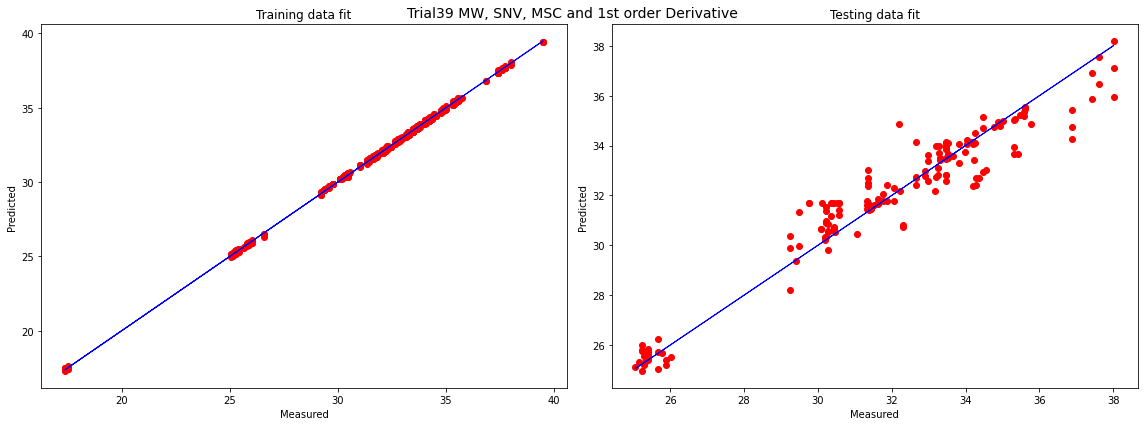

In [79]:
#Trial 39 Moving window , SNV, MSC and 1st order Derivative
#Input for derivative is an array
print("Trial 39")
print("PRE PROCESSING STEP: Moving window , SNV, MSC and 1st order Derivative")
#window length is 19 same as that for moving window smoothing
with tf.device('/device:GPU:0'):
  preprocessed_spectra = pd.DataFrame(derivate_first(msc(SNV(smooth_fast(spectra, 19, cols)), wave_length), 19), columns=cols)
  data,_ = svm(preprocessed_spectra, y, 'Trial39','MW, SNV, MSC and 1st order Derivative')
  result_df = result_df.append(data, ignore_index=True)

Trial 40
PRE PROCESSING STEP: Moving window , SNV, MSC and 2nd order Derivative


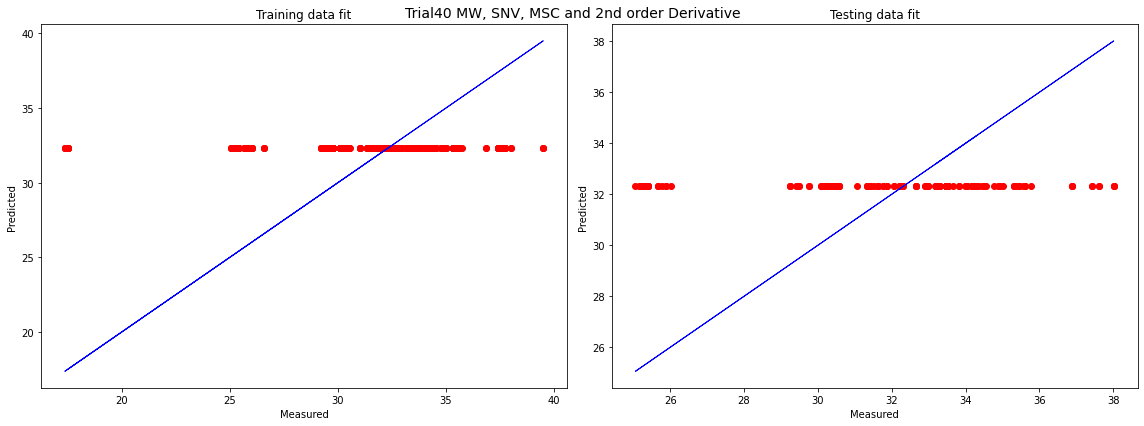

In [80]:
#Trial 40 Moving window , SNV, MSC and 2nd order Derivative
#Input for derivative is an array
print("Trial 40")
print("PRE PROCESSING STEP: Moving window , SNV, MSC and 2nd order Derivative")
#window length is 19 same as that for moving window smoothing
with tf.device('/device:GPU:0'):
  preprocessed_spectra = pd.DataFrame(derivate_second(msc(SNV(smooth_fast(spectra, 19, cols))), 19), columns=cols)
  data,_ = svm(preprocessed_spectra, y, 'Trial40','MW, SNV, MSC and 2nd order Derivative')
  result_df = result_df.append(data, ignore_index=True)

Trial 41
PRE PROCESSING STEP: Moving window, SNV, De-Trending and 1st order Derivative


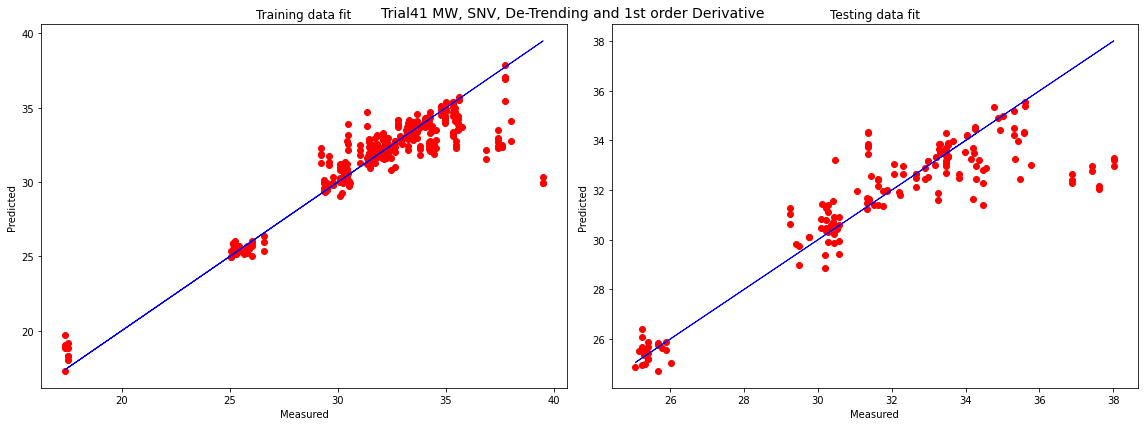

In [81]:
#Trial 41 Moving window, SNV, De-Trending and 1st order Derivative
#Input for derivative is an array
print("Trial 41")
print("PRE PROCESSING STEP: Moving window, SNV, De-Trending and 1st order Derivative")
with tf.device('/device:GPU:0'):
  #window length is 19 same as that for moving window smoothing
  preprocessed_spectra = pd.DataFrame(derivate_first(baseline(SNV(smooth_fast(spectra, 19, cols)), wave_length), 19), columns=cols)
  data,_ = svm(preprocessed_spectra, y, 'Trial41','MW, SNV, De-Trending and 1st order Derivative')
  result_df = result_df.append(data, ignore_index=True)

Trial 42
PRE PROCESSING STEP: Moving window, SNV, De-Trending and 2nd order Derivative


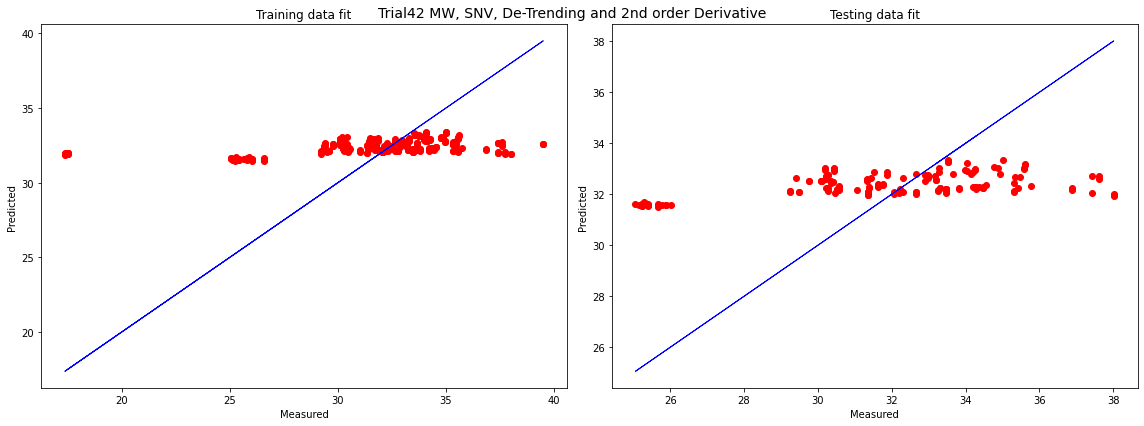

In [82]:
#Trial 42 Moving window, SNV, De-Trending and 2nd order Derivative
#Input for derivative is an array
print("Trial 42")
print("PRE PROCESSING STEP: Moving window, SNV, De-Trending and 2nd order Derivative")
#window length is 19 same as that for moving window smoothing
with tf.device('/device:GPU:0'):
  preprocessed_spectra = pd.DataFrame(derivate_second(baseline(SNV(smooth_fast(spectra, 19, cols)), wave_length), 19), columns=cols)
  data,_ = svm(preprocessed_spectra, y, 'Trial42','MW, SNV, De-Trending and 2nd order Derivative')
  result_df = result_df.append(data, ignore_index=True)

Trial 43
PRE PROCESSING STEP: Moving window, MSC, De-Trending and 1st order Derivative


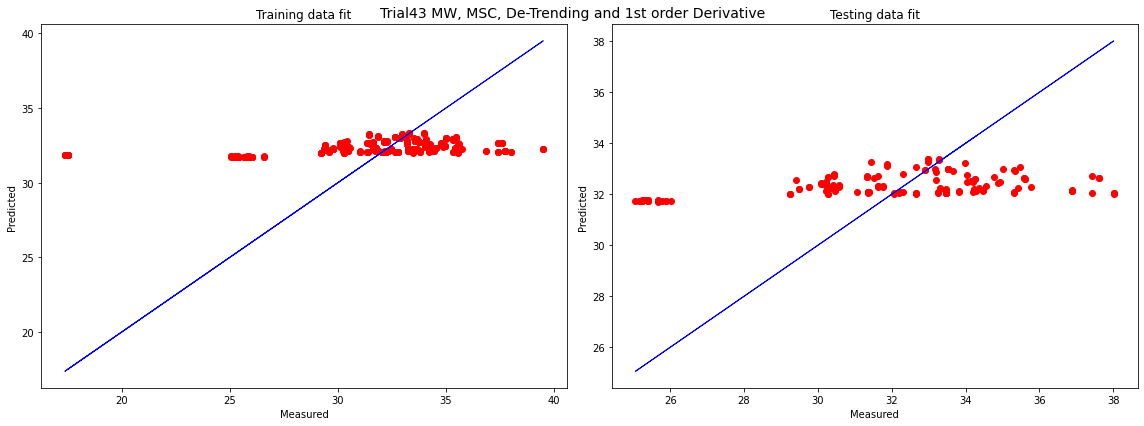

In [83]:
#Trial 43 Moving window, MSC, De-Trending and 1st order Derivative
#Input for derivative is an array
print("Trial 43")
print("PRE PROCESSING STEP: Moving window, MSC, De-Trending and 1st order Derivative")
#window length is 19 same as that for moving window smoothing
with tf.device('/device:GPU:0'):
  preprocessed_spectra = pd.DataFrame(derivate_first(baseline(msc(smooth_fast(spectra, 19, cols)), wave_length), 19), columns=cols)
  data,_ = svm(preprocessed_spectra, y, 'Trial43','MW, MSC, De-Trending and 1st order Derivative')
  result_df = result_df.append(data, ignore_index=True)

Trial 44
PRE PROCESSING STEP: Moving window, MSC, De-Trending and 2nd order Derivative


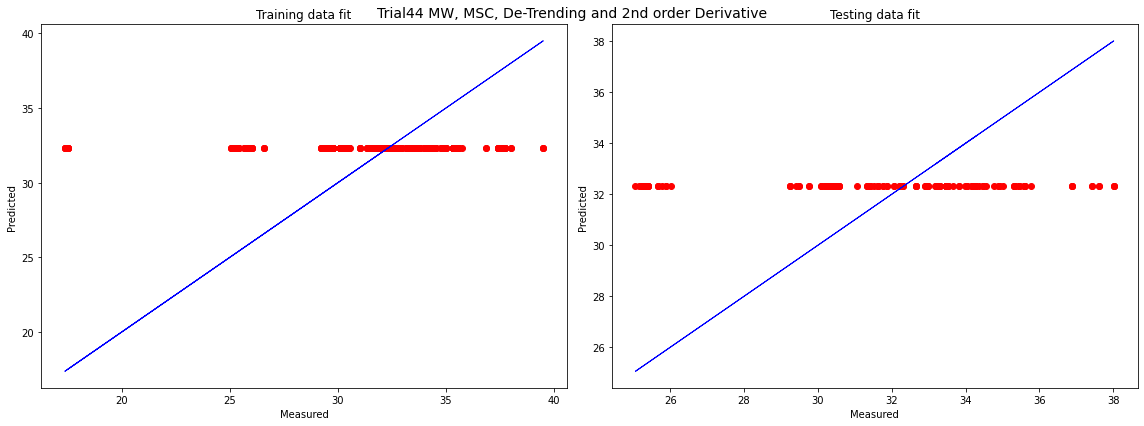

In [84]:
#Trial 44 Moving window, MSC, De-Trending and 2nd order Derivative
#Input for derivative is an array
print("Trial 44")
print("PRE PROCESSING STEP: Moving window, MSC, De-Trending and 2nd order Derivative")
#window length is 19 same as that for moving window smoothing
with tf.device('/device:GPU:0'):
  preprocessed_spectra = pd.DataFrame(derivate_second(baseline(msc(smooth_fast(spectra, 19, cols)), wave_length), 19), columns=cols)
  data,_ = svm(preprocessed_spectra, y, 'Trial44','MW, MSC, De-Trending and 2nd order Derivative')
  result_df = result_df.append(data, ignore_index=True)

Trial 45
PRE PROCESSING STEP: Savitzky Golay, SNV, De-Trending and MSC


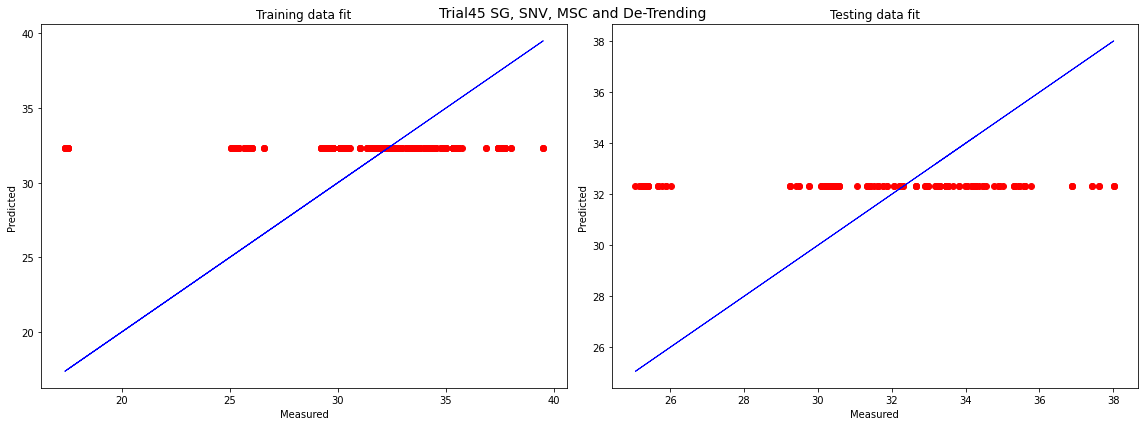

In [85]:
#Trial 45 Savitzky Golay, SNV and De-Trending, MSC
#Input for derivative is an array
print("Trial 45")
print("PRE PROCESSING STEP: Savitzky Golay, SNV, De-Trending and MSC")
#window length is 19 same as that for moving window smoothing
with tf.device('/device:GPU:0'):
  preprocessed_spectra = pd.DataFrame(msc(baseline(SNV(savitzky(spectra, 19)), wave_length)), columns=cols)
  data,_ = svm(preprocessed_spectra, y, 'Trial45','SG, SNV, MSC and De-Trending')
  result_df = result_df.append(data, ignore_index=True)

Trial 46
PRE PROCESSING STEP: Savitzky Golay, SNV, MSC and 1st order Derivative


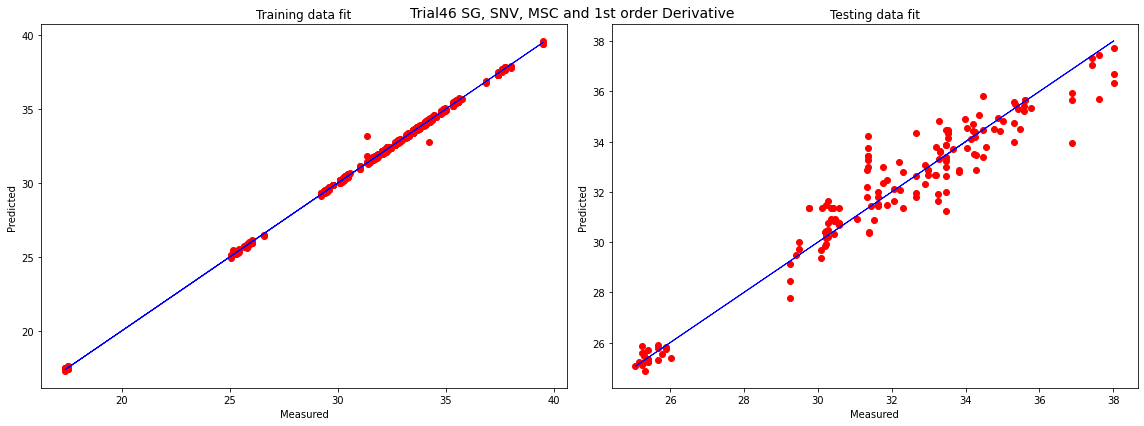

In [86]:
#Trial 46 Savitzky Golay, SNV, MSC and 1st order Derivative
#Input for derivative is an array
print("Trial 46")
print("PRE PROCESSING STEP: Savitzky Golay, SNV, MSC and 1st order Derivative")
#window length is 19 same as that for moving window smoothing
with tf.device('/device:GPU:0'):
  preprocessed_spectra = pd.DataFrame(derivate_first(msc(SNV(savitzky(spectra, 19)), wave_length), 19), columns=cols)
  data,_ = svm(preprocessed_spectra, y, 'Trial46','SG, SNV, MSC and 1st order Derivative')
  result_df = result_df.append(data, ignore_index=True)

Trial 47
PRE PROCESSING STEP: Savitzky Golay, SNV, MSC and 2nd order Derivative


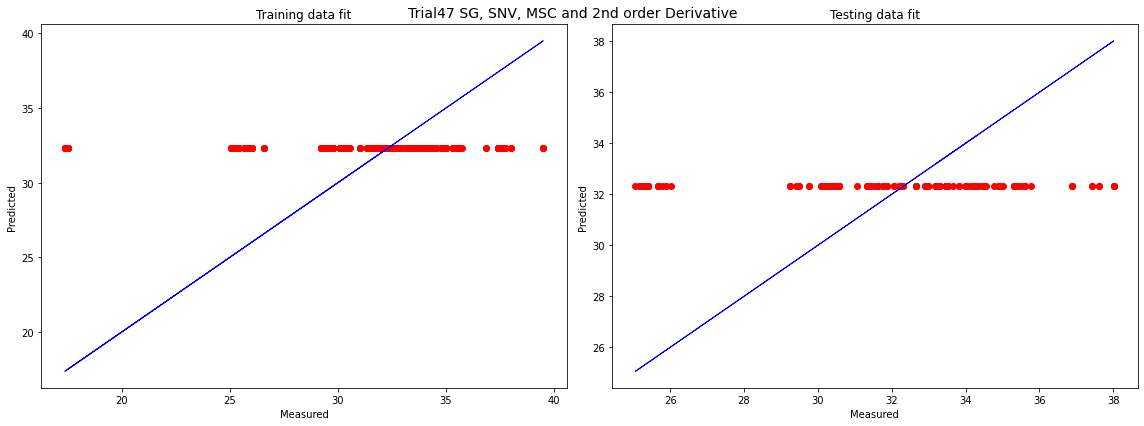

In [87]:
#Trial 47 Savitzky Golay, SNV, MSC and 2nd order Derivative
#Input for derivative is an array
print("Trial 47")
print("PRE PROCESSING STEP: Savitzky Golay, SNV, MSC and 2nd order Derivative")
#window length is 19 same as that for moving window smoothing
with tf.device('/device:GPU:0'):
  preprocessed_spectra = pd.DataFrame(derivate_second(msc(SNV(savitzky(spectra, 19))), 19), columns=cols)
  data,_ = svm(preprocessed_spectra, y, 'Trial47','SG, SNV, MSC and 2nd order Derivative')
  result_df = result_df.append(data, ignore_index=True)

Trial 48
PRE PROCESSING STEP: Savitzky Golay, SNV, De-Trending and 1st order Derivative


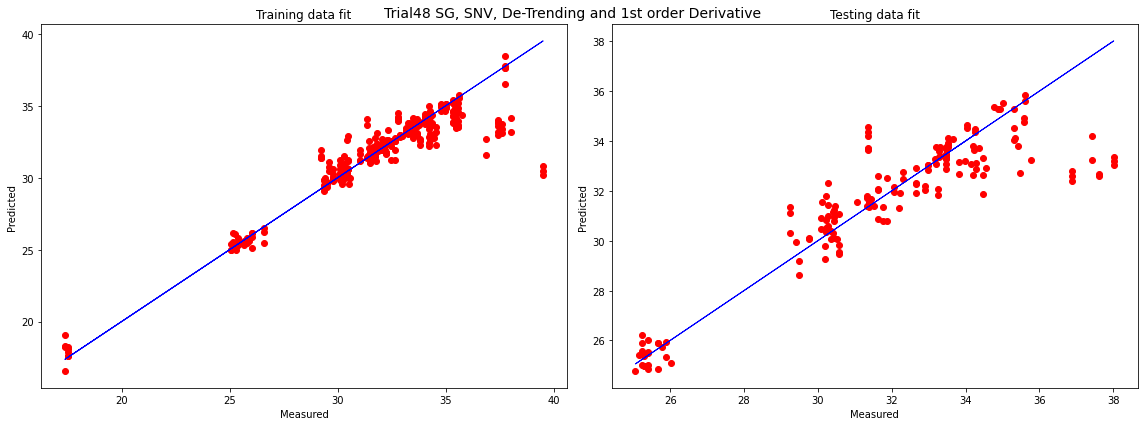

In [88]:
#Trial 48 Savitzky Golay, SNV, De-Trending and 1st order Derivative
#Input for derivative is an array
print("Trial 48")
print("PRE PROCESSING STEP: Savitzky Golay, SNV, De-Trending and 1st order Derivative")
#window length is 19 same as that for moving window smoothing
with tf.device('/device:GPU:0'):
  preprocessed_spectra = pd.DataFrame(derivate_first(baseline(SNV(savitzky(spectra, 19)), wave_length), 19), columns=cols)
  data,_ = svm(preprocessed_spectra, y, 'Trial48','SG, SNV, De-Trending and 1st order Derivative')
  result_df = result_df.append(data, ignore_index=True)

Trial 49
PRE PROCESSING STEP: Savitzky Golay, SNV, De-Trending and 2nd order Derivative


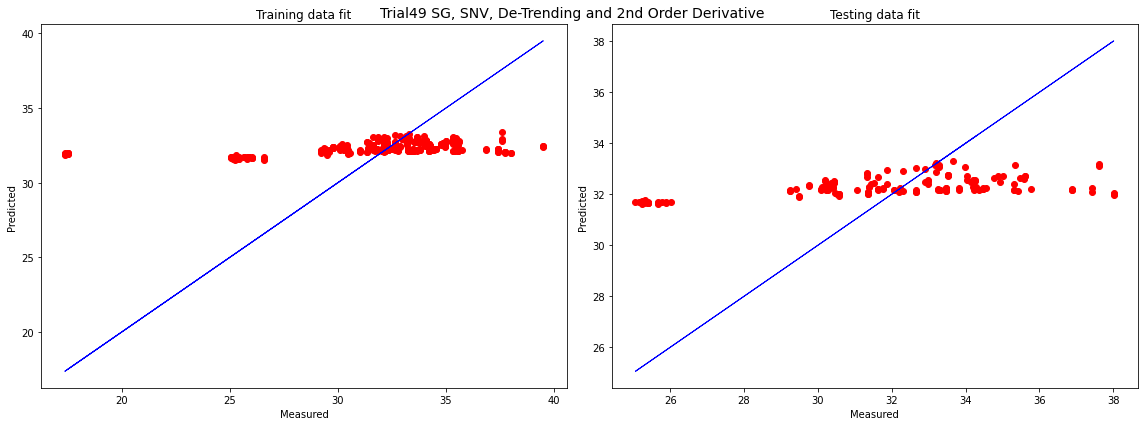

In [89]:
#Trial 49 Savitzky Golay, SNV, De-Trending and 2nd order Derivative
#Input for derivative is an array
print("Trial 49")
print("PRE PROCESSING STEP: Savitzky Golay, SNV, De-Trending and 2nd order Derivative")
#window length is 19 same as that for moving window smoothing
with tf.device('/device:GPU:0'):
  preprocessed_spectra = pd.DataFrame(derivate_second(baseline(SNV(savitzky(spectra, 19)), wave_length), 19), columns=cols)
  data,_ = svm(preprocessed_spectra, y, 'Trial49','SG, SNV, De-Trending and 2nd Order Derivative')
  result_df = result_df.append(data, ignore_index=True)

Trial 50
PRE PROCESSING STEP: Savitzky Golay, MSC, De-Trending and 1st order Derivative


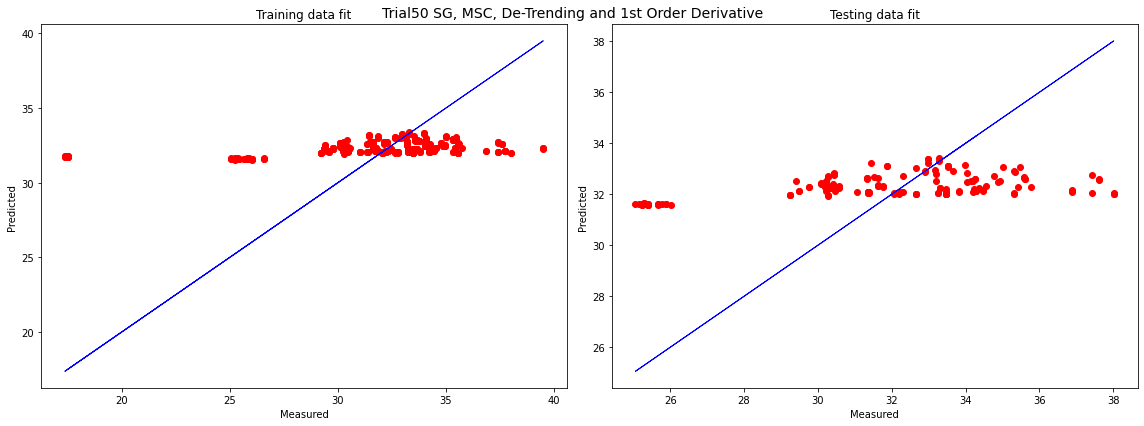

In [90]:
#Trial 50 Savitzky Golay, MSC, De-Trending and 1st order Derivative
#Input for derivative is an array
print("Trial 50")
print("PRE PROCESSING STEP: Savitzky Golay, MSC, De-Trending and 1st order Derivative")
#window length is 19 same as that for moving window smoothing
with tf.device('/device:GPU:0'):
  preprocessed_spectra = pd.DataFrame(derivate_first(baseline(msc(savitzky(spectra, 19)), wave_length), 19), columns=cols)
  data,_ = svm(preprocessed_spectra, y, 'Trial50','SG, MSC, De-Trending and 1st Order Derivative')
  result_df = result_df.append(data, ignore_index=True)

Trial 51
PRE PROCESSING STEP: Savitzky Golay, MSC, De-Trending and 2nd order Derivative


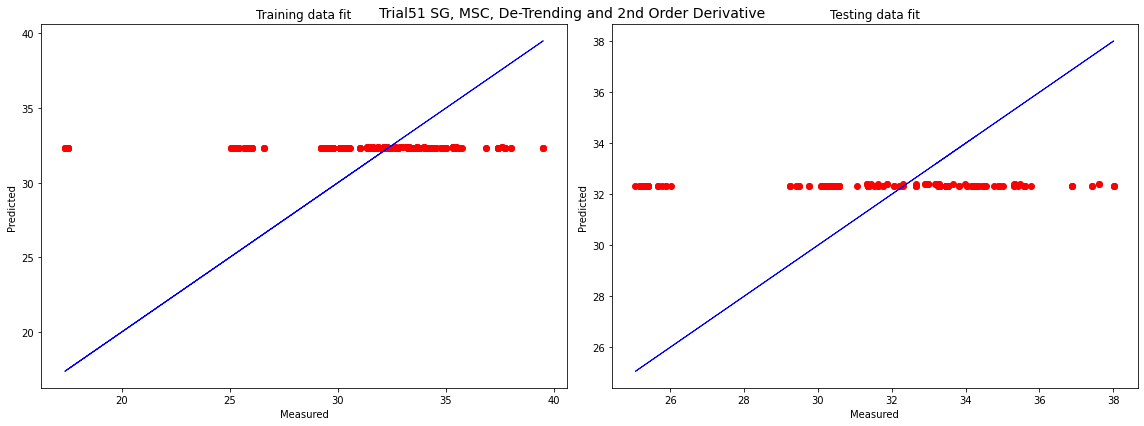

In [91]:
#Trial 51 Savitzky Golay, MSC, De-Trending and 2nd order Derivative
#Input for derivative is an array
print("Trial 51")
print("PRE PROCESSING STEP: Savitzky Golay, MSC, De-Trending and 2nd order Derivative")
#window length is 19 same as that for moving window smoothing
with tf.device('/device:GPU:0'):
  preprocessed_spectra = pd.DataFrame(derivate_second(baseline(msc(savitzky(spectra, 19)), wave_length), 19), columns=cols)
  data,_ = svm(preprocessed_spectra, y, 'Trial51','SG, MSC, De-Trending and 2nd Order Derivative')
  result_df = result_df.append(data, ignore_index=True)

Trial 52
PRE PROCESSING STEP: Moving window , SNV, De-Trending, MSC and 1st Order Derivative


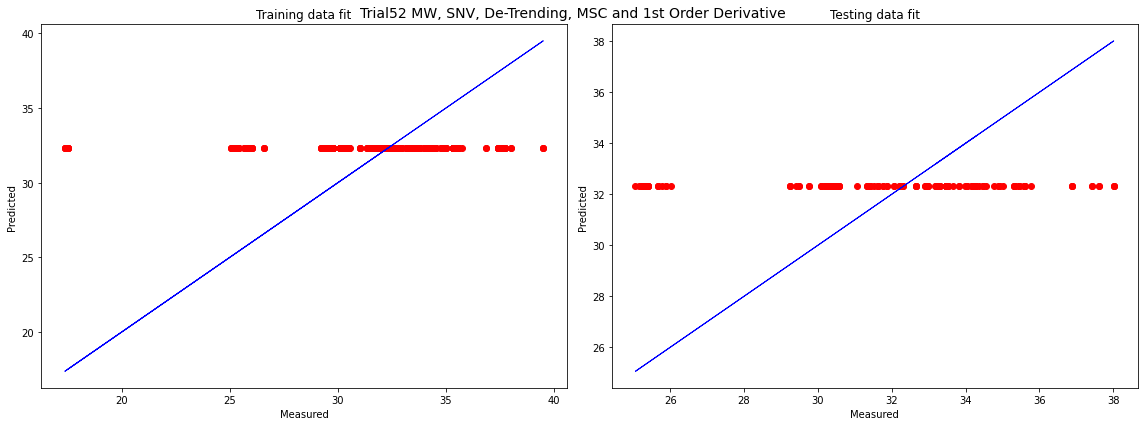

In [92]:
#Trial 52 Moving window , SNV, De-Trending, MSC and 1st Order Derivative
#Input for derivative is an array
print("Trial 52")
print("PRE PROCESSING STEP: Moving window , SNV, De-Trending, MSC and 1st Order Derivative")
#window length is 19 same as that for moving window smoothing
with tf.device('/device:GPU:0'):
  preprocessed_spectra = pd.DataFrame(derivate_first(msc(baseline(SNV(smooth_fast(spectra, 19, cols)), wave_length)), 19), columns=cols)
  data,_ = svm(preprocessed_spectra, y, 'Trial52','MW, SNV, De-Trending, MSC and 1st Order Derivative')
  result_df = result_df.append(data, ignore_index=True)

Trial 53
PRE PROCESSING STEP: Moving window , SNV, De-Trending, MSC and 2nd Order Derivative


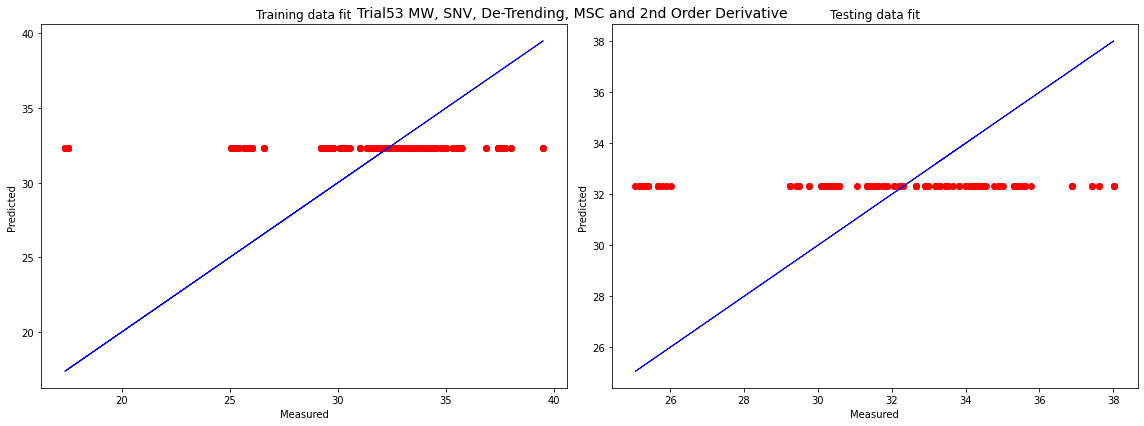

In [93]:
#Trial 53 Moving window , SNV, De-Trending, MSC and 2nd Order Derivative
#Input for derivative is an array
print("Trial 53")
print("PRE PROCESSING STEP: Moving window , SNV, De-Trending, MSC and 2nd Order Derivative")
#window length is 19 same as that for moving window smoothing
with tf.device('/device:GPU:0'):
  preprocessed_spectra = pd.DataFrame(derivate_second(msc(baseline(SNV(smooth_fast(spectra, 19, cols)), wave_length)), 19), columns=cols)
  data,_ = svm(preprocessed_spectra, y, 'Trial53','MW, SNV, De-Trending, MSC and 2nd Order Derivative')
  result_df = result_df.append(data, ignore_index=True)

Trial 54
PRE PROCESSING STEP: Savitzky Golay, SNV, De-Trending, MSC and 1st Order Derivative


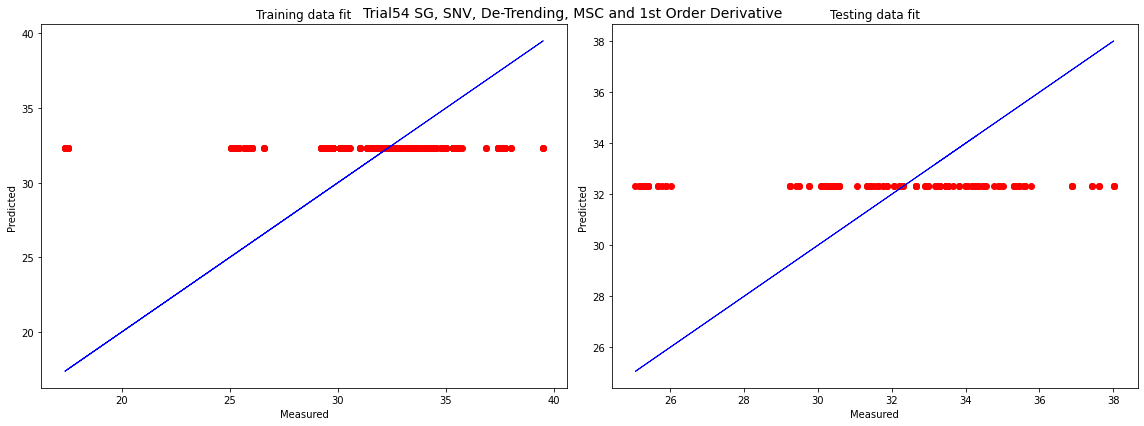

In [94]:
#Trial 54 Savitzky Golay, SNV, De-Trending, MSC and 1st Order Derivative
#Input for derivative is an array
print("Trial 54")
print("PRE PROCESSING STEP: Savitzky Golay, SNV, De-Trending, MSC and 1st Order Derivative")
#window length is 19 same as that for moving window smoothing
with tf.device('/device:GPU:0'):
  preprocessed_spectra = pd.DataFrame(derivate_first(msc(baseline(SNV(savitzky(spectra, 19)), wave_length)), 19), columns=cols)
  data,_ = svm(preprocessed_spectra, y, 'Trial54','SG, SNV, De-Trending, MSC and 1st Order Derivative')
  result_df = result_df.append(data, ignore_index=True)

Trial 55
PRE PROCESSING STEP: Savitzky Golay, SNV, De-Trending, MSC and 2nd Order Derivative


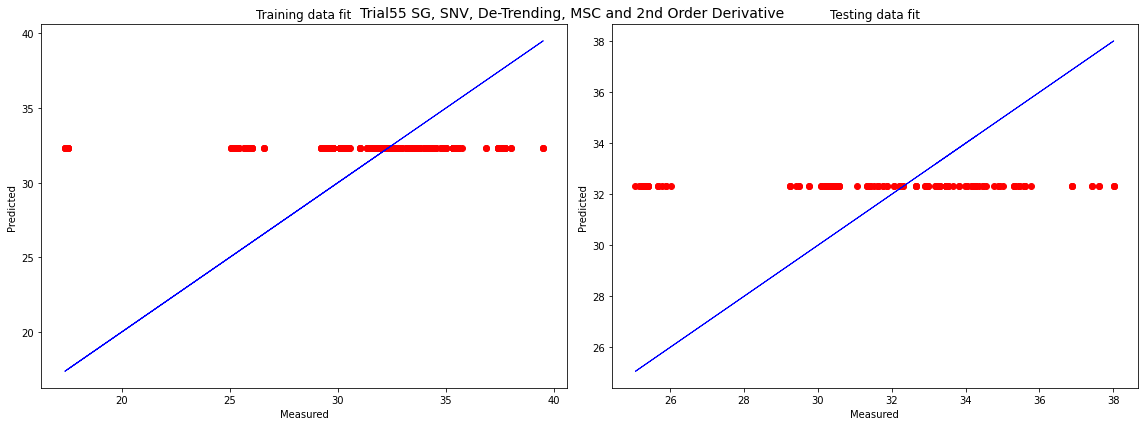

In [95]:
#Trial 55 Savitzky Golay, SNV, De-Trending, MSC and 2nd Order Derivative
#Input for derivative is an array
print("Trial 55")
print("PRE PROCESSING STEP: Savitzky Golay, SNV, De-Trending, MSC and 2nd Order Derivative")
#window length is 19 same as that for moving window smoothing
with tf.device('/device:GPU:0'):
  preprocessed_spectra = pd.DataFrame(derivate_second(msc(baseline(SNV(savitzky(spectra, 19)), wave_length)), 19), columns=cols)
  data,_ = svm(preprocessed_spectra, y, 'Trial55','SG, SNV, De-Trending, MSC and 2nd Order Derivative')
  result_df = result_df.append(data, ignore_index=True)

### Printing the results from different combinations of Pre-Processing steps
1. Moving window (MW)
2. Savitzky Golay (SG)
3. Multiplicative Scatter Correction (MSC)
4. Standard Normal Variate(SNV)
5. De-Trending
6. 1st Order Derivative (SG)
7. 2nd Order Derivative (SG)

In [96]:
result_df.sort_values(["Validation R²"], ascending = False).head(5)

,Trial No,Model,Pre Processing,Training R²,Validation R²,Best fit Hyperparameters
29,Trial30,SVM,"SG, SNV and De-Trending",0.998789,0.950593,"{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}"
13,Trial14,SVM,Savitzky Golay smoothing and SNV,0.995940,0.942451,"{'C': 1000, 'gamma': 0.01, 'kernel': 'rbf'}"
19,Trial20,SVM,"MW, SNV and De-Trending",0.997226,0.941861,"{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}"
3,Trial4,SVM,SNV,0.983158,0.934418,"{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}"
38,Trial39,SVM,"MW, SNV, MSC and 1st order Derivative",0.999382,0.929620,"{'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}"


In [97]:
result_df.sort_values(["Validation R²"], ascending = False).to_csv(file_path+"SVM_results.csv")

#### Ran the Trial 30 Separately:
1. Training R² :0.9843410373004549
2. Validation R² :0.947900154456116

#### Ran all the trials in sequence. The following results were obtained. 
1. Training R² :0.997662
2. Validation R² :0.963639

In [71]:
spectra = np.asarray(X, dtype = float)
cols = X.columns
wave_length = wavelength_calc(X)#

In [74]:
#Recreating Trial 30 
#model SVM Regression
#pre-processing techniques SG, SNV, De-Trending
#{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}
#r-square train = 0.997662
#r_square test = 0.963639
#Trial 30 Savtizky Golay , SNV and Baseline
print("Recreating Trial 30")
print("PRE PROCESSING STEP: Savitzky Golay smoothing, SNV and De-Trending")
#window length is 19 same as that for moving window smoothing
from sklearn.svm import SVR
with tf.device('/device:GPU:0'):
  preprocessed_spectra = pd.DataFrame(baseline(SNV(savitzky(spectra, 19)), wave_length), columns=cols)
  X_train, X_test, y_train, y_test = train_test_split(preprocessed_spectra, y, test_size=0.20, random_state=135)
  sv_regression = SVR(C=100, gamma=0.1, kernel='rbf')
  sv_regression.fit(X_train, y_train)
  print('Training R\u00b2 :' + str(sv_regression.score(X_train,y_train)))
  print('Validation R\u00b2 :' + str(sv_regression.score(X_test,y_test)))

Recreating Trial 30
PRE PROCESSING STEP: Savitzky Golay smoothing, SNV and De-Trending
Training R² :0.997545468970374
Validation R² :0.9699218467421551


Testing on previously unseen dataset

* Saving the model into a binary file
* Running the model from the file on unseen data set



In [98]:
filename = 'finalized_SVM_model.sav'
pickle.dump(model, open(file_path+filename, 'wb'))

In [99]:
spectra = np.asarray(X_test, dtype = float)
cols = X_test.columns
wave_length = wavelength_calc(X)#

In [101]:
#load model from file
model_file = file_path+filename
loaded_model = pickle.load(open(model_file, 'rb'))
result = loaded_model.score(X_test, y_test)

In [102]:
print("Testing R\u00b2 : " +str(result))

Testing R² : -0.00982176482313979


### Saving the results into a csv file

In [ ]:
result_df.to_csv("SVM_results.csv")

### The best fit model : The model that has best R square values training and validation set

#### In our case Trial 30 is the best fit model
1. Model used : SVM
2. Pre-Processing Techniques used: SG, SNV and De-Trending
3. R_square :Training 99%
4. R_square :Validation 80%